In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator

import matplotlib.ticker as plticker

from pandas.plotting import table
from scipy import stats
from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import zscore
from scipy.ndimage import label

import math

# interactive figures
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# misc
import warnings


# Datetime is both a top-level module as well as being a type within that module.
import time
from datetime import datetime, timedelta

# Need to re-import datetime module to avoid confusing with sub-module.
import datetime as dt

In [2]:
data = pd.read_csv("/Users/lisajin/Documents/Smnology/company_data/Reporting/bodimetrics_data1.csv",encoding = "ISO-8859-1")



headers = np.array(data.columns)  # get headers
values = data.values  # numpy array of values
matrix = np.concatenate([[headers], values])  # append to the final matrix



In [3]:
data

First Name Last Name Medical ID Device Model  Device Serial # Device Mode  \
0       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
1       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
2       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
3       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
4       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
5       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
6       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
7       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
8       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
9       Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
10      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
11      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
12      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
13      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
14      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
15      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
16      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
17      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
18      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
19      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
20      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
21      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
22      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
23      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
24      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
25      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
26      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
27      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
28      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
29      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
30      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
31      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
32      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
33      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   
34      Brian       Yam     bky123       Circul  C11E32004003237  Sleep SpO2   

        Observation                                              Value  Units  \
0            Avg HR                                                 59    NaN   
1          Duration                                              28454    NaN   
2          Min SpO2                                    84.696189880371    NaN   
3        <90% Drops                                                 57    NaN   
4          Avg SpO2                                    97.650268554688    NaN   
5           startAt                                         1608191101    NaN   
6             endAt                                         1608219555    NaN   
7          stopType                                                  0    NaN   
8      Deep Minutes                                                124    NaN   
9       Rem Minutes                                                 93    NaN   
10     lightMinutes                                                169    NaN   
11      wakeMinutes                                                 88    NaN   
12   offhandMinutes                                                  

In [4]:
# Get target rows for data arrays.
spo2_arr = data[data['Observation'] == 'o2Arr']
pr_arr = data[data['Observation'] == 'prArr']
stage_arr = data[data['Observation'] == 'stageArr']

# Get specific cells from the corresponding rows to extract integer arrays.
spo2_arr = spo2_arr.iat[0,7]
pr_arr = pr_arr.iat[0,7]
stage_arr = stage_arr.iat[0,7]

# Parse data from the string extracts into lists.
spo2_arr = [float(i) for i in spo2_arr.split(',')]
pr_arr = [int(i) for i in pr_arr.split(',')] 
stage_arr = [int(i) for i in stage_arr.split(',')] 

# Map integer values to string type -> sleep stage categories.
for i in stage_arr:
    if i == 0 or i == 6:
        stage_arr.append('Awake')
    if i == 2:
        stage_arr.append('REM')
    if i == 3:
        stage_arr.append('Light REM')
    if i == 4:
        stage_arr.append('Deep REM')
        
# Additional check to remove integer values from the list.
stage_arr = [x for x in stage_arr if not isinstance(x, int)]

In [5]:
# Get target rows for each sleep stage observation.
dur = data[data['Observation'] == 'Duration']
deep = data[data['Observation'] == 'Deep Minutes']
rem = data[data['Observation'] == 'Rem Minutes']
light = data[data['Observation'] == 'lightMinutes']
wake = data[data['Observation'] == 'wakeMinutes']
odi3 = data[data['Observation'] == 'ODI3']
t90 = data[data['Observation'] == 'shareUnder90']

# Get specific values for durations of the corresponding sleep stages.
deep_minutes = deep.iat[0,7]
rem_minutes = rem.iat[0,7]
light_minutes = light.iat[0,7]
wake_minutes = wake.iat[0,7]
odi3 = odi3.iat[0,7]
t90 = t90.iat[0,7]

# Convert all from string to integer values.
deep_minutes = int(deep_minutes)
rem_minutes = int(rem_minutes)
light_minutes = int(light_minutes)
wake_minutes = int(wake_minutes)
duration_minutes = int(dur.iat[0,7])/60
duration_seconds = int(dur.iat[0,7])%60

# Duration formatting for study info header.
duration_hours = math.floor(duration_minutes/60)
duration_min = math.floor(duration_minutes - (duration_hours*60))
duration_sec = duration_seconds*60

# Convert to floating point numbers.
odi3 = float(odi3)
t90 = float(t90)

# User/study information.
fname = dur.iat[0,0]
lname = dur.iat[0,1]
date = dur.iat[0,9][:10]
t1 = dur.iat[0,9][11:]

# Extract time frame.
t1 = datetime.strptime(t1, "%H:%M:%S")
t1 = t1.time()

# Set increments for collection points (1 second/per data point -> SpO2, 1 minute per data point -> sleep stage)
seconds_increment = 0
minute_increment = 0

# Initialize arrays to store time series.
spo2_time_series = []
stage_arr_series = []

# Populate SpO2 time series array with appropriate time increments.
i = 0
while i < len(spo2_arr):
    delta = dt.timedelta(seconds = seconds_increment)
    new_time = (dt.datetime.combine(dt.date(1,1,1), t1) + delta).time()
    spo2_time_series.append(new_time)
    seconds_increment += 1
    i += 1
    
# Populate sleep stage time series array with appropriate time increments.
i = 0
while i < len(stage_arr):
    delta = dt.timedelta(seconds = minute_increment)
    new_time = (dt.datetime.combine(dt.date(1,1,1), t1) + delta).time()
    stage_arr_series.append(new_time)
    minute_increment += 60
    i += 1

# Initialize additional array to hold formatted time series.
spo2_time_series2 = []
stage_arr_series2 = []

# Convert times from military to standard format.
for t2 in spo2_time_series:
    t2 = t2.strftime("%I:%M %p")
    spo2_time_series2.append(t2)
    
for t2 in stage_arr_series:
    t2 = t2.strftime("%I:%M %p")
    stage_arr_series2.append(t2)

In [6]:
# Print user info.
print("   Name: ", fname, "", lname, " | ", "Test: ", date , " | ", "Duration: ", duration_hours, "hrs,", duration_min, "min,", duration_seconds, "sec")

   Name:  Brian  Yam  |  Test:  2020-12-16  |  Duration:  7 hrs, 54 min, 14 sec


In [7]:
# Define min/max/avg heart rate data.
non_zero_values = [i for i in pr_arr if i != 0]
min_hr = min(non_zero_values)
avg_hr = sum(non_zero_values)/len(non_zero_values)
max_hr = max(pr_arr)

# Define bar chart attributes.
hr_labels = ['Minimum', 'Average', 'Maximum']
hr_values = [min_hr, avg_hr, max_hr]

In [8]:
# Define min/max/avg oxygen saturation values.
non_zero_values = [i for i in spo2_arr if i != 0]
min_spo2 = min(non_zero_values)
avg_spo2 = sum(non_zero_values)/len(non_zero_values)
max_spo2 = max(spo2_arr)

# Define bar chart attributes.
spo2_labels = ['Minimum', 'Average', 'Maximum']
spo2_values = [min_spo2, avg_spo2, max_spo2]

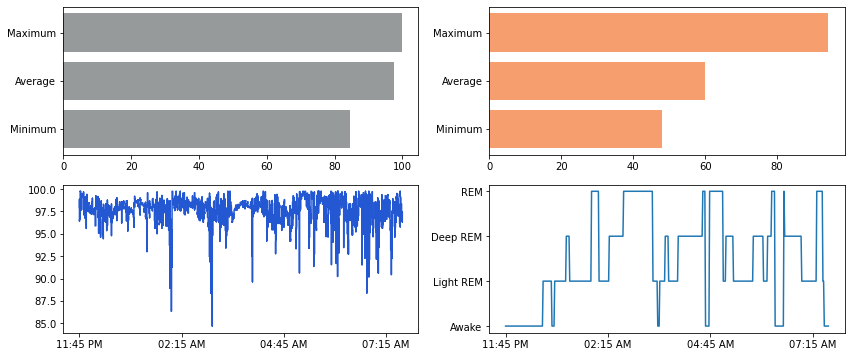

In [9]:
# Subplots of bar charts.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,6))

# Oxygen saturation subplot.
ax1.barh(spo2_labels, spo2_values, color='#979A9A')
#ax1.set_title('% Oxygen Saturation')

# Heart rate subplot.
ax2.barh(hr_labels, hr_values, color='#F69E6D')
#ax2.set_title('Heart Rate (BPM)')

# Remove all zeros and replace with NaN.
spo2_arr = [np.nan if x == 0 else x for x in spo2_arr]

# Oxygen saturation time series subplot.
#ax3.locator_params(axis='x', nbins=10)
ax3.xaxis.set_major_locator(plt.MaxNLocator(5))
ax3.plot(spo2_time_series2, spo2_arr, color='#2358D2')
#ax3.set_title('% Oxygen Saturation Over Time')

# Sleep stages subplot.
ax4.xaxis.set_major_locator(plt.MaxNLocator(5))
ax4.plot(stage_arr_series2, stage_arr)
#ax4.set_title('Sleep Stages Over Time')

# Margin and spacing adjustments.
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.9, hspace=1)

plt.show()

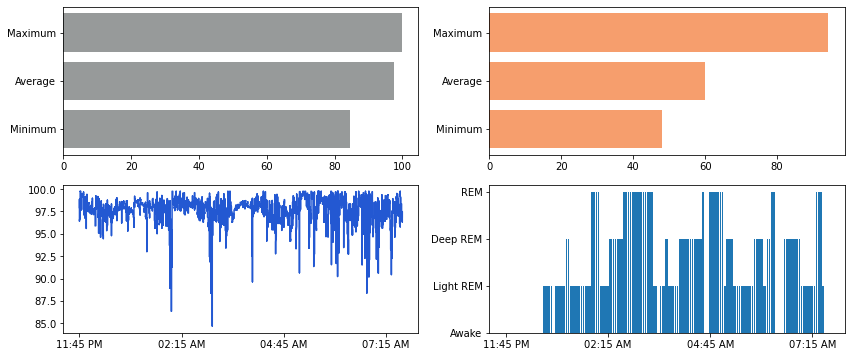

In [10]:
# Subplots of bar charts.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,6))

# Oxygen saturation subplot.
ax1.barh(spo2_labels, spo2_values, color='#979A9A')
#ax1.set_title('% Oxygen Saturation')

# Heart rate subplot.
ax2.barh(hr_labels, hr_values, color='#F69E6D')
#ax2.set_title('Heart Rate (BPM)')

# Remove all zeros and replace with NaN.
spo2_arr = [np.nan if x == 0 else x for x in spo2_arr]

# Oxygen saturation time series subplot.
#ax3.locator_params(axis='x', nbins=10)
ax3.xaxis.set_major_locator(plt.MaxNLocator(5))
ax3.plot(spo2_time_series2, spo2_arr, color='#2358D2')
#ax3.set_title('% Oxygen Saturation Over Time')

# Sleep stages subplot.
ax4.xaxis.set_major_locator(plt.MaxNLocator(5))
ax4.bar(stage_arr_series2, stage_arr)
#ax4.set_title('Sleep Stages Over Time')

# Margin and spacing adjustments.
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.9, hspace=1)

plt.show()

In [103]:
BDI=data[data['Observation'] == 'ODI3']
#BDI=BDI['Value']

#BDI.plot(x ='Value', kind = 'bar')

In [107]:
BDI=eval(data[data.Observation == 'ODI3'].Value.squeeze())
BDI

7.6165804862976

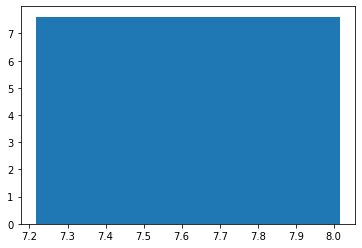

In [114]:
# Horizontal Bar Plot

plt.bar(BDI,BDI)
 
# Show Plot
plt.show()

# Sleep stages bar graph

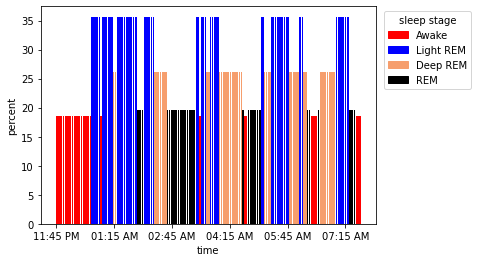

In [11]:
from collections import Counter
x = stage_arr_series2
y=stage_arr
counter=Counter(stage_arr)
stage_arr_freq = [100*counter[stage_arr[i]]/len(stage_arr) for i in range(0,len(stage_arr))]
color_by_stage = {'Awake': 'r', 'Light REM': 'b', 'Deep REM': '#F69E6D', 'REM':'k'}
fig, ax = plt.subplots()
ax.bar(x,stage_arr_freq,color = [color_by_stage[i] for i in stage_arr],label= ['Awake','Light REM','Deep REM','REM'])
loc = plticker.MultipleLocator(base=90) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.set_ylabel('percent')
ax.set_xlabel('time')
labels = color_by_stage.keys()
handles = [plt.Rectangle((0,0),1,1, color=color_by_stage[l]) for l in labels]
plt.legend(handles, labels, title="sleep stage",bbox_to_anchor=(1.3, 1),loc = "upper right")

plt.show()


In [12]:
stage_arr

['Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Li

In [14]:
y


['Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Awake',
 'Awake',
 'Awake',
 'Awake',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Light REM',
 'Li

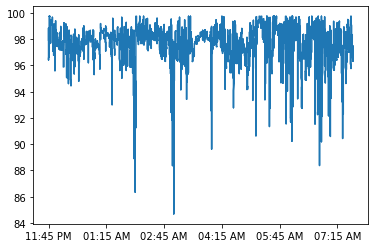

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

x = spo2_time_series2
y = spo2_arr
fig, ax = plt.subplots()
ax.plot(x,y)
loc = plticker.MultipleLocator(base=90) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.show()

In [16]:
raw=data[data.Observation == 'o2Arr'].Value.squeeze()#oxygen level in string type
pulse_str=data[data.Observation == 'prArr'].Value.squeeze()#pulse in string type

stage_str=data[data.Observation == 'stageArr'].Value.squeeze()#stage in string


In [17]:
#convert points of interest to list
oxy=list(eval(raw))
pulse=list(eval(pulse_str))
stage=list(eval(stage_str))

In [18]:
df1 = pd.DataFrame(oxy,columns=['oxy_level'])

df1['pulse_sec']=pulse



In [19]:
df1 = pd.concat([df1,pd.Series(stage)],ignore_index=False, axis=1)



In [20]:
df1

oxy_level  pulse_sec    0
0          97.93         68  0.0
1          98.07         68  0.0
2          98.23         68  0.0
3          98.39         68  0.0
4          98.60         68  0.0
...          ...        ...  ...
28449      97.39         89  NaN
28450      97.40         89  NaN
28451      97.46         89  NaN
28452      97.47         89  NaN
28453      97.47         90  NaN

[28454 rows x 3 columns]

In [21]:
stage=df1[0]
df1['stage_min']=stage
del df1[0]

In [22]:
df1

oxy_level  pulse_sec  stage_min
0          97.93         68        0.0
1          98.07         68        0.0
2          98.23         68        0.0
3          98.39         68        0.0
4          98.60         68        0.0
...          ...        ...        ...
28449      97.39         89        NaN
28450      97.40         89        NaN
28451      97.46         89        NaN
28452      97.47         89        NaN
28453      97.47         90        NaN

[28454 rows x 3 columns]

In [23]:
stagemin_length=df1['stage_min'].count()

In [24]:
stage_min=df1['stage_min'][0:stagemin_length] #not nan
stage_sec=stage_min.repeat(60)
stage_sec = stage_sec.reset_index(drop = True)
df1['stage_sec']=stage_sec


In [25]:
df1

oxy_level  pulse_sec  stage_min  stage_sec
0          97.93         68        0.0        0.0
1          98.07         68        0.0        0.0
2          98.23         68        0.0        0.0
3          98.39         68        0.0        0.0
4          98.60         68        0.0        0.0
...          ...        ...        ...        ...
28449      97.39         89        NaN        NaN
28450      97.40         89        NaN        NaN
28451      97.46         89        NaN        NaN
28452      97.47         89        NaN        NaN
28453      97.47         90        NaN        NaN

[28454 rows x 4 columns]

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28454 entries, 0 to 28453
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   oxy_level  28454 non-null  float64
 1   pulse_sec  28454 non-null  int64  
 2   stage_min  474 non-null    float64
 3   stage_sec  28440 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 889.3 KB


In [27]:
df1['stage_sec'] = df1['stage_sec'].fillna(0)

In [28]:
df1 # this is the dataset where we unpack the arrays for oxygen leve, pulse and stage addition with mins and now sec 

oxy_level  pulse_sec  stage_min  stage_sec
0          97.93         68        0.0        0.0
1          98.07         68        0.0        0.0
2          98.23         68        0.0        0.0
3          98.39         68        0.0        0.0
4          98.60         68        0.0        0.0
...          ...        ...        ...        ...
28449      97.39         89        NaN        0.0
28450      97.40         89        NaN        0.0
28451      97.46         89        NaN        0.0
28452      97.47         89        NaN        0.0
28453      97.47         90        NaN        0.0

[28454 rows x 4 columns]

# ODI Calculation using oxygen intake raw data

In this section, we are going to calculate the percentage oxygen level intake drops. The data point is compared with the 91% level, and the data is also calculated based on the rolling of five seconds. Meaning, for one particular data point, we compare this data with the previous 5 second data points average. And if the drop is 3 percent, we denote it as ODI3, and if the drop is 4 percent, we denote it as ODI4, etc. In this dataset, our sample is healthy data, for the purpose of demonstration, we are calculating ODI1 and ODI2; but in the future, we can change our calculation metric algorithm and show ODI4 and ODI5. 

/Users/lisajin/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='oxy_level'>

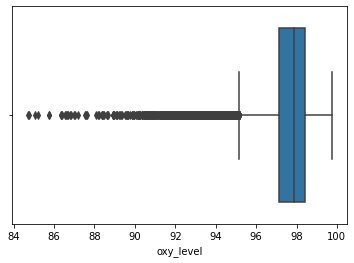

In [29]:
sns.boxplot(df1.oxy_level)

In [30]:
#establish a metric or standard oxygen level (not the baseline because we cannot measure the baseline)
#we acquire this by excludig the outliers see in the above graph and get the standard metric o2
#we exclude the outliers that happen due to the machine malfunction

Q1 = df1['oxy_level'].quantile(0.25)
Q3 = df1['oxy_level'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df1['oxy_level'] >= Q1 - 1.5 * IQR) & (df1['oxy_level'] <= Q3 + 1.5 *IQR)
df_filter=df1.loc[filter]  

In [31]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27157 entries, 0 to 28453
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   oxy_level  27157 non-null  float64
 1   pulse_sec  27157 non-null  int64  
 2   stage_min  474 non-null    float64
 3   stage_sec  27157 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1.0 MB


In [32]:
oxygen_metric=df_filter['oxy_level'].mean()

In [33]:
oxygen_metric #this is just the average of the night, not the reference line 

97.82013771771506

In [34]:
interval=df_filter['oxy_level']-90 #the reference line is at 90% of oxygen intake level

In [35]:
df_filter['interval']=interval

<ipython-input-35-8d1e39be196c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['interval']=interval


In [36]:
df_filter

oxy_level  pulse_sec  stage_min  stage_sec  interval
0          97.93         68        0.0        0.0      7.93
1          98.07         68        0.0        0.0      8.07
2          98.23         68        0.0        0.0      8.23
3          98.39         68        0.0        0.0      8.39
4          98.60         68        0.0        0.0      8.60
...          ...        ...        ...        ...       ...
28449      97.39         89        NaN        0.0      7.39
28450      97.40         89        NaN        0.0      7.40
28451      97.46         89        NaN        0.0      7.46
28452      97.47         89        NaN        0.0      7.47
28453      97.47         90        NaN        0.0      7.47

[27157 rows x 5 columns]

In [37]:
#max and min oxygen level and expected oxygen level
max_oxy=max(df1['oxy_level'])
min_oxy=min(df1['oxy_level'])
std_oxy=df_filter['oxy_level'].std()
expect_oxy=[oxygen_metric-std_oxy,oxygen_metric+std_oxy]
expect_oxy

[96.9021228609466, 98.73815257448351]

Text(0.5, 1.0, 'Baseline and Raw O2 Data')

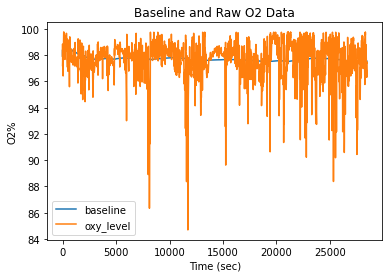

In [38]:
#set up slow-moving average filter parameters to establish baseline and support comparison for artifact detection
t_slow =10800 #assume that "t_slow" in sample data refers to slow-moving average time constant for baseline.  This is a guess.
eventReadings = 1 #require this many consecutive readings below desat threshold before scoring event
desatThreshold = 3 #percent below baseline
artifactRate = 3 #don't register desaturation events if O2 changes by more than this rate from one reading to the next (percent)
longEventDuration = 60 #number of seconds required to score "long" event

df1['baseline'] = df1['oxy_level'].rolling(t_slow,min_periods = 1).mean()

df1.plot(y=['baseline','oxy_level'])
plt.xlabel('Time (sec)')
plt.ylabel('O2%')
plt.title('Baseline and Raw O2 Data')

In [39]:
df_filter['reference'] = df_filter['oxy_level'].rolling(5,min_periods = 1).mean()

<ipython-input-39-1a3fe6fdb231>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['reference'] = df_filter['oxy_level'].rolling(5,min_periods = 1).mean()


In [40]:
df_filter

oxy_level  pulse_sec  stage_min  stage_sec  interval  reference
0          97.93         68        0.0        0.0      7.93  97.930000
1          98.07         68        0.0        0.0      8.07  98.000000
2          98.23         68        0.0        0.0      8.23  98.076667
3          98.39         68        0.0        0.0      8.39  98.155000
4          98.60         68        0.0        0.0      8.60  98.244000
...          ...        ...        ...        ...       ...        ...
28449      97.39         89        NaN        0.0      7.39  97.320000
28450      97.40         89        NaN        0.0      7.40  97.378000
28451      97.46         89        NaN        0.0      7.46  97.410000
28452      97.47         89        NaN        0.0      7.47  97.428000
28453      97.47         90        NaN        0.0      7.47  97.438000

[27157 rows x 6 columns]

In [41]:
interval_ind=(df_filter['oxy_level']-df_filter['reference'])/df_filter['reference']*100 #interval percentage based off of personal data per every 5 seconds

In [42]:
df_filter['interval_ind']=interval_ind
df_filter

<ipython-input-42-6cd495977d0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['interval_ind']=interval_ind


oxy_level  pulse_sec  stage_min  stage_sec  interval  reference  \
0          97.93         68        0.0        0.0      7.93  97.930000   
1          98.07         68        0.0        0.0      8.07  98.000000   
2          98.23         68        0.0        0.0      8.23  98.076667   
3          98.39         68        0.0        0.0      8.39  98.155000   
4          98.60         68        0.0        0.0      8.60  98.244000   
...          ...        ...        ...        ...       ...        ...   
28449      97.39         89        NaN        0.0      7.39  97.320000   
28450      97.40         89        NaN        0.0      7.40  97.378000   
28451      97.46         89        NaN        0.0      7.46  97.410000   
28452      97.47         89        NaN        0.0      7.47  97.428000   
28453      97.47         90        NaN        0.0      7.47  97.438000   

       interval_ind  
0          0.000000  
1          0.071429  
2          0.156340  
3          0.239417  
4          0.362363  
...             ...  
28449      0.071928  
28450      0.022592  
28451      0.051329  
28452      0.043109  
28453      0.032841  

[27157 rows x 7 columns]

Text(0.5, 1.0, 'raw O2 Data and 90% reference')

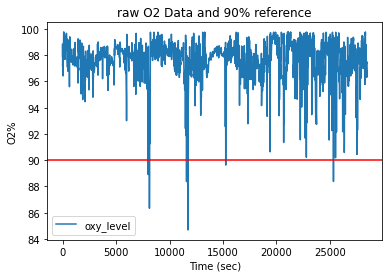

In [43]:
#overall oxygen level comparing to the reference line which is at 91%
df1.plot(y=['oxy_level'])
plt.axhline(y=90, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('O2%')
ax.plot(x,y)
loc = plticker.MultipleLocator(base=90) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.title('raw O2 Data and 90% reference')


Text(0.5, 1.0, 'filtered O2 Data and 90% reference')

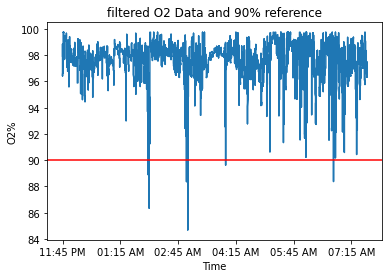

In [44]:
#filtered oxygen level, where the oxygen levels are only accounted not due to device malfunction
#comparing to the reference line which is at 91%
#df_filter.plot(y=['oxy_level'])
x = spo2_time_series2
y = spo2_arr
fig, ax = plt.subplots()
ax.plot(x,y)
loc = plticker.MultipleLocator(base=90) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.axhline(y=90, color='r', linestyle='-')
plt.xlabel('Time')
plt.ylabel('O2%')
plt.title('filtered O2 Data and 90% reference')

Text(0.5, 1.0, 'filtered O2 Data and 90% reference')

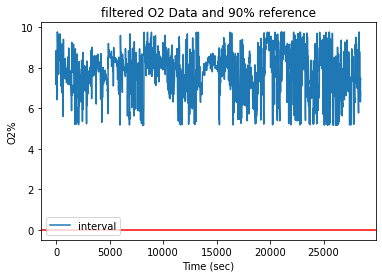

In [45]:
df_filter.plot(y=['interval'])
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('O2%')
plt.title('filtered O2 Data and 90% reference')


In [46]:
#filter out the positive interval because they are fine (healthy to have high oxygen level, right?)

df_filter_neg=df_filter[(df_filter['interval_ind'] <= 0)]

In [47]:
df_filter_neg

oxy_level  pulse_sec  stage_min  stage_sec  interval  reference  \
0          97.93         68        0.0        0.0      7.93     97.930   
7          98.46         68        0.0        0.0      8.46     98.622   
8          97.94         68        0.0        0.0      7.94     98.532   
9          97.16         68        0.0        0.0      7.16     98.244   
10         97.20         68        0.0        0.0      7.20     97.914   
...          ...        ...        ...        ...       ...        ...   
28428      96.60         89        NaN        0.0      6.60     96.616   
28429      96.61         89        NaN        0.0      6.61     96.610   
28441      96.32         89        NaN        0.0      6.32     96.696   
28442      96.44         89        NaN        0.0      6.44     96.636   
28443      96.58         89        NaN        0.0      6.58     96.598   

       interval_ind  
0      0.000000e+00  
7     -1.642636e-01  
8     -6.008200e-01  
9     -1.103375e+00  
10    -7.292113e-01  
...             ...  
28428 -1.656040e-02  
28429 -4.118662e-13  
28441 -3.888475e-01  
28442 -2.028230e-01  
28443 -1.863393e-02  

[14235 rows x 7 columns]

In [48]:
min(df_filter_neg['interval_ind'])

-1.8841533651476288

In [49]:
ODI3=df_filter_neg['interval_ind'] <= -3 # ODI 3%, oxygen level drops more or equal to 3 percent
ODI2=df_filter_neg['interval_ind'] <= -2  # ODI 2%, oxygen level drops more or equal to 2 percent
ODI1=df_filter_neg['interval_ind'] <= -1  # ODI 1%, oxygen level drops more or equal to 1 percent

In [50]:
ODI3

0        False
7        False
8        False
9        False
10       False
         ...  
28428    False
28429    False
28441    False
28442    False
28443    False
Name: interval_ind, Length: 14235, dtype: bool

In [51]:
df_filter_neg['ODI1']=ODI1
df_filter_neg['ODI2']=ODI2
df_filter_neg['ODI3']=ODI3

<ipython-input-51-81ed0c887039>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_neg['ODI1']=ODI1
<ipython-input-51-81ed0c887039>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_neg['ODI2']=ODI2
<ipython-input-51-81ed0c887039>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [52]:
df_filter_neg['ODI'] = df_filter_neg['interval_ind'].values

<ipython-input-52-a11872e6578a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_neg['ODI'] = df_filter_neg['interval_ind'].values


In [53]:
# create a list of our conditions
conditions = [
    (df_filter_neg['interval_ind'] <=-3),
    (df_filter_neg['interval_ind'] <=-2) & (df_filter_neg['interval_ind'] >-3),
    (df_filter_neg['interval_ind'] >-2 ) & (df_filter_neg['interval_ind'] <=-1)
    ]

# create a list of the values we want to assign for each condition
values = ['ODI3', 'ODI2', 'ODI1']

# create a new column and use np.select to assign values to it using our lists as arguments
df_filter_neg['ODI'] = np.select(conditions, values)

# display updated DataFrame
df_filter_neg.head()

<ipython-input-53-ce0c4ad8b750>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_neg['ODI'] = np.select(conditions, values)


oxy_level  pulse_sec  stage_min  stage_sec  interval  reference  \
0       97.93         68        0.0        0.0      7.93     97.930   
7       98.46         68        0.0        0.0      8.46     98.622   
8       97.94         68        0.0        0.0      7.94     98.532   
9       97.16         68        0.0        0.0      7.16     98.244   
10      97.20         68        0.0        0.0      7.20     97.914   

    interval_ind   ODI1   ODI2   ODI3   ODI  
0       0.000000  False  False  False     0  
7      -0.164264  False  False  False     0  
8      -0.600820  False  False  False     0  
9      -1.103375   True  False  False  ODI1  
10     -0.729211  False  False  False     0

# Mark the ones with significant drop, ODI1 in this case: (This set does not have other ODI data)

In [54]:
df_plot=df_filter_neg[df_filter_neg.interval_ind <-1]

In [55]:
df_plot

oxy_level  pulse_sec  stage_min  stage_sec  interval  reference  \
9          97.16         68        0.0        0.0      7.16     98.244   
6845       95.72         66        NaN        3.0      5.72     96.780   
6846       95.32         66        NaN        3.0      5.32     96.308   
11741      95.97         51        NaN        2.0      5.97     97.032   
11742      95.40         51        NaN        2.0      5.40     96.560   
15211      95.48         60        NaN        4.0      5.48     96.470   
15245      96.35         72        NaN        4.0      6.35     97.686   
15246      95.60         72        NaN        4.0      5.60     97.074   
15261      95.19         73        NaN        4.0      5.19     96.452   
16997      96.25         72        NaN        4.0      6.25     97.314   
16998      95.82         70        NaN        4.0      5.82     96.844   
17325      95.49         64        NaN        4.0      5.49     96.468   
18596      95.59         62        NaN        2.0      5.59     96.710   
18626      95.23         63        NaN        2.0      5.23     96.216   
20243      95.67         60        NaN        3.0      5.67     96.706   
20268      97.14         55        NaN        3.0      7.14     98.272   
20269      96.24         55        NaN        3.0      6.24     97.696   
20270      95.61         55        NaN        3.0      5.61     97.052   
20271      95.29         55        NaN        3.0      5.29     96.428   
20705      97.75         69        NaN        3.0      7.75     98.930   
20706      96.89         69        NaN        3.0      6.89     98.376   
20707      95.97         69        NaN        3.0      5.97     97.664   
21076      97.34         55        NaN        3.0      7.34     98.756   
22347      97.17         49        NaN        4.0      7.17     98.282   
22348      96.41         49        NaN        4.0      6.41     97.716   
22349      95.52         49        NaN        4.0      5.52     97.046   
22363      95.41         49        NaN        4.0      5.41     96.458   
22661      96.39         58        NaN        4.0      6.39     97.498   
22662      95.85         58        NaN        4.0      5.85     96.978   
22663      95.41         58        NaN        4.0      5.41     96.452   
22778      98.12         62        NaN        3.0      8.12     99.140   
22779      97.39         62        NaN        3.0      7.39     98.668   
22780      96.48         62        NaN        3.0      6.48     98.020   
22781      95.40         62        NaN        3.0      5.40     97.232   
22804      95.18         63        NaN        3.0      5.18     96.514   
22868      95.23         65        NaN        3.0      5.23     96.234   
23292      95.87         55        NaN        4.0      5.87     97.066   
23306      95.40         54        NaN        4.0      5.40     96.622   
23463      97.08         56        NaN        2.0      7.08     98.224   
23484      97.37         57        NaN        2.0      7.37     98.478   
24921      97.15         65        NaN        4.0      7.15     98.488   
24922      96.18         65        NaN        4.0      6.18     97.852   
24932      95.71         65        NaN        4.0      5.71     97.158   
25183      96.25         55        NaN        4.0      6.25     97.464   
25212      95.36         53        NaN        4.0      5.36     96.916   
25318      95.77         53        NaN        4.0      5.77     96.824   
25334      95.22         53        NaN        4.0      5.22     96.320   
25377      95.68         54        NaN        4.0      5.68     96.720   
25553      96.95         59        NaN        4.0      6.95     98.188   
25554      96.08         59        NaN        4.0      6.08     97.606   
25555      95.19         59        NaN        4.0      5.19     96.876   
26661      96.65         54        NaN        3.0      6.65     97.652   
28056      97.23         55        NaN        0.0      7.23     98.700   
28057      

In [56]:
index = df_plot.index
index

Int64Index([    9,  6845,  6846, 11741, 11742, 15211, 15245, 15246, 15261,
            16997, 16998, 17325, 18596, 18626, 20243, 20268, 20269, 20270,
            20271, 20705, 20706, 20707, 21076, 22347, 22348, 22349, 22363,
            22661, 22662, 22663, 22778, 22779, 22780, 22781, 22804, 22868,
            23292, 23306, 23463, 23484, 24921, 24922, 24932, 25183, 25212,
            25318, 25334, 25377, 25553, 25554, 25555, 26661, 28056, 28057,
            28097],
           dtype='int64')

Text(0.5, 1.0, 'filtered O2 Data with 90% and average oxygen level ')

<Figure size 1440x504 with 0 Axes>

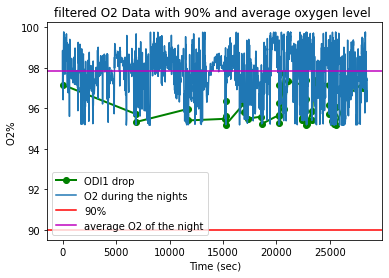

In [57]:

plt.figure(figsize=(20, 7))
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(df_plot['oxy_level'],'go-', label='ODI1 drop', linewidth=2)

ax1.plot(df_filter['oxy_level'],label='O2 during the nights')
#ax1.plot(spo2_time_series2, stage_arr)
plt.axhline(y=90, color='r', linestyle='-',label='90%')

plt.axhline(y=oxygen_metric, color='m', linestyle='-',label='average O2 of the night')
plt.xlabel('Time (sec)')
plt.ylabel('O2% ')
plt.legend()
#ax.legend('ODI1 drop points','Oxygen intake level','91% standard level','average for the night')
plt.title('filtered O2 Data with 90% and average oxygen level ')


In [58]:
#plt.figure(figsize=(20, 7))
##fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

#ax1.plot(df_plot['oxy_level'],'go-', label='ODI1 drop', linewidth=2)
#
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.plot(spo2_time_series2, spo2_arr, color='#2358D2')
#ax3.set_title('% Oxygen Saturation Over Time')

<ipython-input-58-9507c9183bab>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig1.add_subplot(111)


In [59]:
#t90 events:
df_t90=df1[df1.oxy_level<90]
#df_t90
index_t90 = df_t90.index
index_t90

Int64Index([ 8002,  8003,  8004,  8005,  8006,  8007,  8008,  8009,  8116,
             8117,  8118,  8119,  8120,  8121,  8122,  8123,  8124,  8125,
             8126,  8127,  8128,  8129,  8130,  8131, 11589, 11590, 11591,
            11592, 11593, 11594, 11595, 11596, 11679, 11680, 11709, 11710,
            11711, 11712, 11713, 11714, 11715, 11716, 11717, 11718, 11719,
            11720, 11721, 11722, 11723, 15254, 15255, 15256, 25325, 25326,
            25327, 25328, 25329],
           dtype='int64')

In [60]:
#see if the interval of each event is 1, if not 1 meaning it is not continous
t90_con=[j-i for i, j in zip(index_t90[:-1], index_t90[1:])]
n=np.abs(t90_con)
print(n)

[    1     1     1     1     1     1     1   107     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1  3458
     1     1     1     1     1     1     1    83     1    29     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
  3531     1     1 10069     1     1     1     1]


In [61]:
# add the continopus events togther 
from itertools import groupby
list1 = n
count_dups = [sum(1 for _ in group) for _, group in groupby(list1)]
#count_dups.remove(1)
print(len(count_dups))
print(count_dups)

13
[7, 1, 15, 1, 7, 1, 1, 1, 14, 1, 2, 1, 4]


In [62]:
valueToBeRemoved = 1
 
try:
    while True:
        count_dups.remove(valueToBeRemoved)
except ValueError:
    pass
 
print(count_dups)

[7, 15, 7, 14, 2, 4]


In [63]:
t_90=len(df_t90['oxy_level'])

In [64]:
t_90percent=t_90/len(df_filter['oxy_level'])*100

In [65]:
t_90percent

0.20989063593180396

# SpO2% graph

Your T90 happens 57 seconds in total for the night.
Your T90 percentage of the night is 0.20989063593180396 %
Continuous T90 happens during the night is 6 times.
Your longest T90 happens is 15 seconds.


<Figure size 1440x504 with 0 Axes>

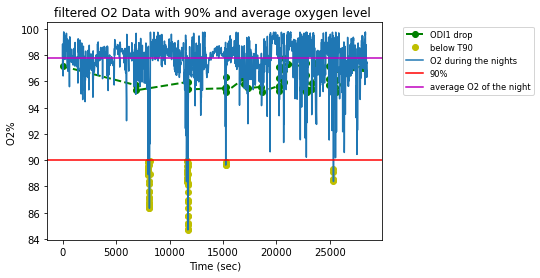

In [66]:
# use a unfiltered data just as reference because the filtered data perfrom so well, hard to see the T90
#having some difficulties to implement the time to x axis directly since the dimension of T90 and the others are different


plt.figure(figsize=(20, 7))
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(df_plot['oxy_level'],'go--', label='ODI1 drop', linewidth=2)
ax1.plot(df_t90['oxy_level'],'o', color='y',label='below T90', linewidth=2)

ax1.plot(df1['oxy_level'],label='O2 during the nights')
plt.axhline(y=90, color='r', linestyle='-',label='90%')

plt.axhline(y=oxygen_metric, color='m', linestyle='-',label='average O2 of the night')
plt.xlabel('Time (sec)')
plt.ylabel('O2% ')
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
#ax.legend('ODI1 drop points','Oxygen intake level','91% standard level','average for the night')
plt.title('filtered O2 Data with 90% and average oxygen level ')
print('Your T90 happens'+' '+str(t_90)+' '+'seconds in total for the night.')
print('Your T90 percentage of the night is'+' '+str(t_90percent)+' '+'%')
print('Continuous T90 happens during the night is'+' '+str(len(count_dups))+' '+'times.')
print('Your longest T90 happens is'+' '+str(max(count_dups))+' '+'seconds.')


Your T90 happens 57 seconds in total for the night.
Continuous T90 happens during the night is 6 times.
Your longest T90 happens is 15 seconds.


<Figure size 1440x504 with 0 Axes>

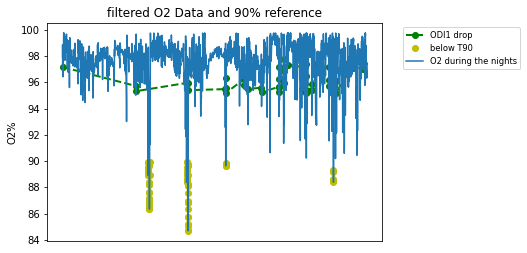

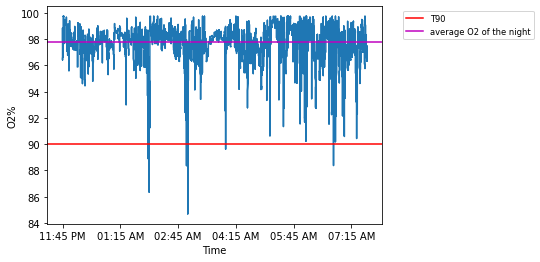

In [67]:
plt.figure(figsize=(20, 7))
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(df_plot['oxy_level'],'go--', label='ODI1 drop', linewidth=2)
ax1.plot(df_t90['oxy_level'],'o', color='y',label='below T90', linewidth=2)

ax1.plot(df1['oxy_level'],label='O2 during the nights')
#plt.axhline(y=90, color='r', linestyle='-',label='90%')
ax1.axes.xaxis.set_visible(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.ylabel('O2%')
plt.title('filtered O2 Data and 90% reference')


x = spo2_time_series2
y = spo2_arr
fig, ax = plt.subplots()
ax.plot(x,y)
loc = plticker.MultipleLocator(base=90) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.axhline(y=90, color='r', linestyle='-',label='T90')
plt.axhline(y=oxygen_metric, color='m', linestyle='-',label='average O2 of the night')
plt.xlabel('Time')
plt.ylabel('O2%')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
#plt.title('filtered O2 Data and 90% reference')
print('Your T90 happens'+' '+str(t_90)+' '+'seconds in total for the night.')
print('Continuous T90 happens during the night is'+' '+str(len(count_dups))+' '+'times.')
print('Your longest T90 happens is'+' '+str(max(count_dups))+' '+'seconds.')


In [68]:
#Drops equivalent or more than 3% event
event_ODI3 = sum(ODI3)

#Drops equivalent or more than 2% event
event_ODI2 = sum(ODI2)

#Drops equivalent or more than 1% event
event_ODI1 = sum(ODI1)

#drops 1% only
event_ODI1_only=event_ODI1-event_ODI2

#drops 2% only
event_ODI2_only=event_ODI2-event_ODI3


In [69]:
event_ODI=[event_ODI3,event_ODI2,event_ODI1]
print(event_ODI)
#event_ODI_only=[event_ODI3_only,event_ODI2_only,event_ODI1]
#event_ODI_only

[0, 0, 55]


Text(0.0, 1.0, 'Oxygen performance comparing to 90% level in percent\n')

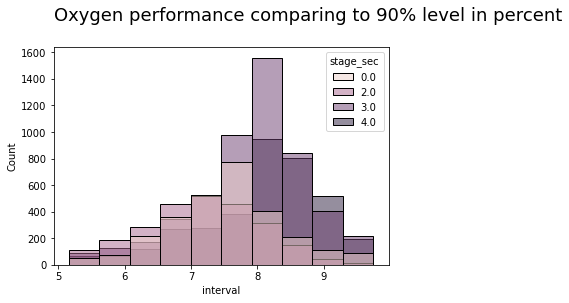

In [70]:
#stage corresponding to drop/increase comparing to 90% levels
sns.histplot(data=df_filter_neg, x='interval',
             hue='stage_sec',
             cbar=True,
             bins=10)
plt.title("Oxygen performance comparing to 90% level in percent\n",
          fontsize=18, loc='left'
         )

In [71]:
ODI_by_stage=df_filter_neg.groupby(['stage_sec'])['ODI3','ODI2','ODI1'].sum()

<ipython-input-71-e47f22636699>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ODI_by_stage=df_filter_neg.groupby(['stage_sec'])['ODI3','ODI2','ODI1'].sum()


In [72]:
ODI_by_stage

ODI3  ODI2  ODI1
stage_sec                  
0.0           0     0     4
2.0           0     0     6
3.0           0     0    18
4.0           0     0    27

Text(0.0, 1.0, 'ODI level by sleep stage\n')

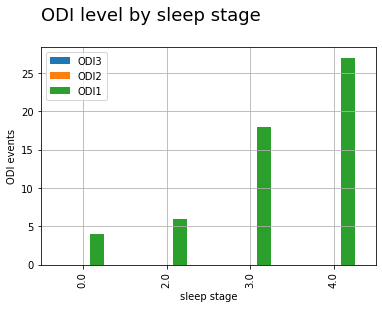

In [78]:
ODI_by_stage.plot.bar(stacked=False);


plt.xlabel('sleep stage')
plt.ylabel('ODI events')
plt.grid(True)
plt.title("ODI level by sleep stage\n",
          fontsize=18, loc='left'
         )

In [79]:
total_event=len(df1)
oxy_level_1=sum(df1['oxy_level']<95) #events that is less than 95percent 
oxy_level_2=sum(df1['oxy_level']<90) #events that is less than 95percent 
oxy_level_3=sum(df1['oxy_level']<85) #events that is less than 85percent 
oxy_level_4=sum(df1['oxy_level']<80) #events that is less than 80percent

oxygen_average=round(oxygen_metric)


percent_oxy_level_1="{:.0%}".format(oxy_level_1/total_event) #percentage events that is less than 95percent
percent_oxy_level_2="{:.0%}".format(oxy_level_2/total_event) #percentage events that is less than 90percent
percent_oxy_level_3="{:.0%}".format(oxy_level_3/total_event) #percentage events that is less than 85percent
percent_oxy_level_4="{:.0%}".format(oxy_level_4/total_event) #percentage events that is less than 80percent



PR=int(df1['pulse_sec'].mean()) #average pulse rate

sleep_stage0=int(sum(df1['stage_sec']==0)/60) #sleep stage 0 in mins
sleep_stage1=int(sum(df1['stage_sec']==1)/60) #sleep stage 0 in mins
sleep_stage2=int(sum(df1['stage_sec']==2)/60) #sleep stage 0 in mins
sleep_stage3=int(sum(df1['stage_sec']==3)/60) #sleep stage 0 in mins
sleep_stage4=int(sum(df1['stage_sec']==4)/60) #sleep stage 0 in mins



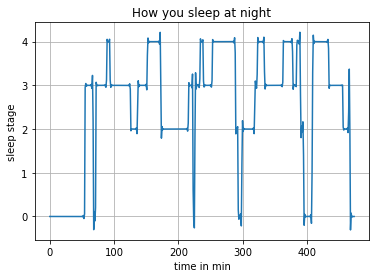

In [80]:
df_spec=df1.dropna()


x = np.arange(0, len(df_spec['stage_min']), 1)

y = df_spec['stage_min'].to_numpy()

X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_)

plt.title("How you sleep at night")
plt.xlabel("time in min")
plt.ylabel("sleep stage")
plt.grid(True)
plt.show()

In [81]:
#print results to terminal for review
print("-----Some Other Relevant Results-----")
#print("Your expected oxygen intake level throughout the night is between" +' '+ str(expect_oxy) +'.')
print("Your average oxygen intake throughout the night is" +' '+ str(oxygen_average) +'%'+'.')
print("Your highest oxygen intake throughout the night is" +' '+ str(max_oxy) +'%'+'.')
print("Your lowest oxygen intake throughout the night is" +' '+ str(min_oxy) +'%'+'.')

print("Your oxygen intake below 95% of the night is" +' '+ str(oxy_level_1) +',' +"that is " + str(percent_oxy_level_1) +'of all the oxygen intake events.')
print("Your oxygen intake below 90% of the night is" +' '+ str(oxy_level_2) +',' +"that is " + str(percent_oxy_level_2) +'of all the oxygen intake events.')
print("Your oxygen intake below 85% of the night is" +' '+ str(oxy_level_3) +',' +"that is " + str(percent_oxy_level_3) +'of all the oxygen intake events.')
print("Your oxygen intake below 80% of the night is" +' '+ str(oxy_level_4) +',' +"that is " + str(percent_oxy_level_4) +'of all the oxygen intake events.')
print("The events of oxygen intake drops more than 3%" +' '+'happend '+ str(event_ODI3)+' '+'time(s).')

print("Your Average pulse rate of the night is " + str(PR) +'.')


print("Your sleep stage 0 of the night is " + str(sleep_stage0) +' '+'mins.')
print("Your sleep stage 1 of the night is " + str(sleep_stage1) + ' '+'mins.')
print("Your sleep stage 2 of the night is " + str(sleep_stage2) + ' '+'mins.')
print("Your sleep stage 3 of the night is " + str(sleep_stage3) +' '+'mins.')
print("Your sleep stage 4 of the night is " + str(sleep_stage4) +' '+'mins.')

-----Some Other Relevant Results-----
Your average oxygen intake throughout the night is 98%.
Your highest oxygen intake throughout the night is 99.75%.
Your lowest oxygen intake throughout the night is 84.69%.
Your oxygen intake below 95% of the night is 1170,that is 4%of all the oxygen intake events.
Your oxygen intake below 90% of the night is 57,that is 0%of all the oxygen intake events.
Your oxygen intake below 85% of the night is 2,that is 0%of all the oxygen intake events.
Your oxygen intake below 80% of the night is 0,that is 0%of all the oxygen intake events.
The events of oxygen intake drops more than 3% happend 0 time(s).
Your Average pulse rate of the night is 60.
Your sleep stage 0 of the night is 88 mins.
Your sleep stage 1 of the night is 0 mins.
Your sleep stage 2 of the night is 93 mins.
Your sleep stage 3 of the night is 169 mins.
Your sleep stage 4 of the night is 124 mins.


# Sleep Efficency and Sleep Score

In this section, we are going to dive into the sleep efficiency calculation. the equation is Total sleep in bed/total time in bed* 100%

And as of Sleep score, Melissa gives five endpoints to look at and we can come up with a formula that suits us the best along with the rating system that our patients give themselves to aid us deciding how to write this algorithm.

But we would like to start with the follow:
Sleep_score=Sleep duration*0.2+sleep onset latency*0.2+SE*0.4+sleep_stage*0.2
Sleep duration (7-9hrs best score, below 6 or beyond 10 bad)
SOL (10-20mins)
Sleep stage: 3+4=15-20%; REM = 20-25%; light (1+2)=50-60%


UPDATE on the equation: sleep_score=sleep_duration_score*0.1+SE_score*0.3+sleep_stage_score*0.02+ODI_score*0.3+heart_rate_score*0.28-wake_time_score*0.1


In [82]:
total_time_in_bed=eval(data[data.Observation == 'Duration'].Value.squeeze())/60 #total time in bed in mins
deep_sleep=eval(data[data.Observation == 'Deep Minutes'].Value.squeeze()) # total deep sleep time in mins 
rem_sleep=eval(data[data.Observation == 'Rem Minutes'].Value.squeeze()) # total rem sleep time in mins 
light_sleep=eval(data[data.Observation == 'lightMinutes'].Value.squeeze()) # total rem sleep time in mins 
wake_time=eval(data[data.Observation == 'wakeMinutes'].Value.squeeze()) #total awake time in mins


sleep_stage3=int(sum(df1['stage_sec']==3)/60) #sleep stage 0 in mins
sleep_stage4=int(sum(df1['stage_sec']==4)/60) #sleep stage 0 in mins
sleep_stage34=sleep_stage3+sleep_stage4
sleep_stage1=int(sum(df1['stage_sec']==1)/60) #sleep stage 0 in mins
sleep_stage2=int(sum(df1['stage_sec']==2)/60) #sleep stage 0 in mins
sleep_stage0=int(sum(df1['stage_sec']==0)/60) #sleep stage 0 in mins
sleep_stage012=sleep_stage1+sleep_stage2+sleep_stage0
#sleep_stage12=sleep_stage1+sleep_stage2
total_sleep_time=total_time_in_bed-wake_time
sleep_efficiency=total_sleep_time/total_time_in_bed
SE_percent="{:.0%}".format(sleep_efficiency)

#it looks like sleep onset latency is not recorded in the dataset, and normally, it takes 10-20 mins, so we take the
#average where we have SOL=15 when it is not specified 
sleep_duration=total_time_in_bed/60 #sleep duration in hours




#print(total_time_in_bed)
#print(deep_sleep)
#print(rem_sleep)
#print(light_sleep)
#print(wake_time)
#print(sleep_stage3)
#print(sleep_stage4)
#print(sleep_stage34)
#print(sleep_stage1)
#print(sleep_stage2)
#print(sleep_stage0)
#print(sleep_stage012)
#print(sleep_stage12)
#print(total_sleep_time)
#print(sleep_efficiency)
print("Your sleep efficiency for the night is "+SE_percent+'.')

Your sleep efficiency for the night is 81%.


In [83]:
#please note here, we do not have a latency varaible, so please change the varaible name accordinly if we have one later
if 'latency' in data.Observation:
    sleep_onset_latency=eval(data[data.Observation == 'latency'].Value.squeeze())
else:
    sleep_onset_latency=15
sleep_onset_latency

15

In [84]:
sleep_duration

7.903888888888889

# how to calculate the sleep score 


In this section, we specifically define the algorithm on how we can calculate the sleep score

we need to make sure that all the varaibles:
sleep duration, sleep onset latency, sleep efficiency and sleep stages have the same measure unit first. As of now, sleep duration, sleep onset latency and sleep stages are in time and sleep efficiency are in percentage. 

we are going to covert the measurement on a percentage basis. 



if sleep duration is between 7-9 hours, we give 100%, in this case, a 1. And this varaible has a weight of 0.4
for every 30 mins less than 7 hours and more than 9 hours, we deduct 5% out of the score, and come up with a sleep duration score in the end.


if sleep onset latency is between 10-20 mins, we give 100%, in this case a 1. And this varaible has a weight of 0.1
if sleep onset latency >20, for every 5 mins, we deduct 10% (this is currently not incorporated because I am not sure how we obtained the data)

sleep efficiency is already in percentage and this varaible weights 0.3


sleep stage score assign 0.02 weight
if sleep deep sleep/total_time_in_bed equals to 15%-20% and REM/total_time_in_bed is 20%-25%, and light sleep/total_time_in_bed 50-60%, then we give 100%, and this variable is 0.02 for the weight. (werables are not accurate in terms of measuring)

for every 5% off, we deduct 5% off the score for this varaible and come up a score.

For heart rate score, we give a weight of 0.28,for bpm between 50-100, we give the full score and for anything below 50 or beyong 100, for every +/-10 bpm, we deduct 5%.


For ODI events, if we have 0 ODI3 event, then we give 100% and the weight is 0.15. For every 5 events, we deduct 5%.



Penality:
We assign waketime score to 0 to start with. And the weight is -0.1. 
For every 20 mins awake, we impose 5% of the penalty to the waktime score. 

In the end, the reward (100% in total) minus the penalty equals to the final sleep score.



Due to the continous research, here we also add T90 as a variable. 
And if T90 >20%, we detect that the patient has a tendency of suffering from obstructive sleep apnea. 
If T90 is 0, we give T90 the maximum score, with every 5% of the T90 increases, we deduct 10% of the T90 score. We assign T90 categgory the smae as ODI, so each of these respiratory category get 0.15 score cattegory and rearrange the weights:





sleep_score=sleep_duration_score*0.1+SE_score*0.3+sleep_stage_score*0.02+ODI_score*0.15+T90_score*0.15+heart_rate_score*0.28-wake_time_score*0.1


In [85]:
sleep_duration_score=1
if 7<=sleep_duration<=9:
    sleep_duration_score=sleep_duration_score
elif sleep_duration<7:
    sleep_duration_score=sleep_duration_score-abs(7-sleep_duration)*0.1
else:
    sleep_duration_score=sleep_duration_score-abs(sleep_duration-9)*0.1
    
print(sleep_duration_score)
    
    

1


In [86]:
sleep_duration_score

1

In [87]:
sleep_onset_latency_score=1
if sleep_onset_latency<=20:
    sleep_onset_latency_score=sleep_onset_latency_score


else:
    sleep_onset_latency_score=sleep_onset_latency_score-abs(sleep_onset_latency-20)*0.1/5
    
print(sleep_onset_latency_score)
    

1


In [88]:
SE_score=sleep_efficiency
SE_score

0.814437337456948

In [89]:
deep_sleep_percent=deep_sleep/total_time_in_bed
rem_sleep_percent=rem_sleep/total_time_in_bed
light_sleep_percent=light_sleep/total_time_in_bed
print(deep_sleep_percent)
print(rem_sleep_percent)

print(light_sleep_percent)

0.26147466085611865
0.19610599564208897
0.356364658747452


In [90]:
deep_sleep_score=1
if 0.15<=deep_sleep_percent<=0.2:
    deep_sleep_score=deep_sleep
elif abs(0.15-deep_sleep_percent)<=abs(deep_sleep_percent-0.2):
    deep_sleep_score=deep_sleep_score-abs(0.15-deep_sleep_percent)/0.05*0.05
else:
    deep_sleep_score=deep_sleep_score-abs(deep_sleep_percent-0.2)/0.05*0.05
print(deep_sleep_score)

0.9385253391438814


In [91]:
rem_sleep_score=1
if 0.2<=rem_sleep_percent<=0.25:
    rem_sleep_score=rem_sleep_score
elif abs(0.2-rem_sleep_percent)<=abs(deep_sleep_percent-0.25):
    rem_sleep_score=rem_sleep_score-abs(0.2-rem_sleep_percent)/0.05*0.05
else:
    
    rem_sleep_score=rem_sleep_score-abs(rem_sleep_percent-0.25)/0.05*0.05
print(rem_sleep_score)

0.996105995642089


In [92]:
light_sleep_score=1
if 0.5<=light_sleep_percent<=0.6:
    light_sleep_score=light_sleep_score
elif abs(0.5-light_sleep_percent)<=abs(light_sleep_percent-0.6):
    light_sleep_score=light_sleep_score-abs(0.5-light_sleep_percent)/0.05*0.05
else:
    
    light_sleep_score=light_sleep_score-abs(light_sleep_percent-0.6)/0.05*0.05
print(light_sleep_score)

0.856364658747452


In [93]:
sleep_stage_score=(deep_sleep_score+rem_sleep_score+light_sleep_score)/3
sleep_stage_score

0.9303319978444741

In [94]:
ODI_score=1
if event_ODI3==0:
    ODI_score=ODI_score
else:
    ODI_score=ODI_score-event_ODI3/5*0.05
print(ODI_score)

1


In [95]:
wake_time_score=0
if wake_time==0:
    wake_time_score=wake_time_score
else:
    wake_time_score=wake_time_score+wake_time/20*0.05
print(wake_time_score)
    

0.22000000000000003


In [96]:
#heart rate:
heart_rate_score=1
if 50<=PR<=100:
    heart_rate_score=heart_rate_score
elif abs(50-PR)<=abs(PR-100):
    heart_rate_score=heart_rate_score-(50-PR)/10*0.05
else:
    heart_rate_score=heart_rate_score-(PR-100)/10*0.05
print(heart_rate_score)
    
    
    

1


In [97]:
t90_score=1
if t_90percent==0:
    t90_score=t90_score
if t_90percent/100/0.05*0.10>1:
    t90_score=0
else:
    t90_score=t90_score-t_90percent/100/0.05*0.10
print(t90_score)

0.9958021872813639


In [98]:
sleep_score=sleep_duration_score*0.1+SE_score*0.3+sleep_stage_score*0.02+ODI_score*0.15+t90_score*0.15+heart_rate_score*0.28-wake_time_score*0.1
sleep_score_percent="{:.0%}".format(sleep_score)
print('Your sleep score of the night is '+sleep_score_percent+'.')

Your sleep score of the night is 92%.


up untill this point, we have calculated our prelimary sleep score. we need to test this algorithm by having patients rating their sleep quality and we check against the sleep score and how they feel in the end. Then we are able to adjust the weights accordinly when we recevie many data to test. 

# Proportion of each category for the score

In [99]:
sleep_duration_por=sleep_duration_score*0.1
SE_score_por=SE_score*0.3
sleep_stage_por=sleep_stage_score*0.02
ODI_score_por=ODI_score*0.15
t90_score_por=t90_score*0.15
heart_rate_por=heart_rate_score*0.28
wake_time_por=wake_time_score*0.1

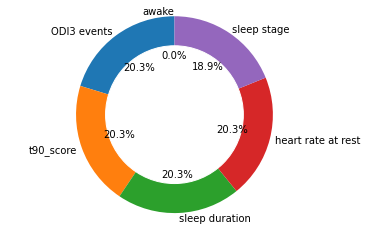

In [100]:
cathegories = ['ODI3 events','t90_score','sleep duration','heart rate at rest','sleep stage','awake']

percent = [round(ODI_score*100),round(t90_score*100),round(sleep_duration_score*100),round(heart_rate_score*100),
          round(sleep_stage_score*100),round(wake_time_score)*100]


my_circle = plt.Circle((0, 0), 0.7, color='white')

d = plt.pie(percent, labels=cathegories, autopct='%1.1f%%',
            startangle=90, labeldistance=1.05)
plt.axis('equal')
plt.gca().add_artist(my_circle)
            
plt.show()

In [101]:
%pip install altair vega_datasets
import altair as alt
df=pd.DataFrame({'Org': ['school1','school1','school1','school1', 'school2', 'school2', 'school2', 'school2'],
                 'variable': ['rose', 'dropped', 'maintained', 'failed','rose', 'dropped', 'maintained', 'failed'],
                'numbers': [25,35,25,45,25,25,25,25], 
                 'position': [12.5, 42.5, 72.5, 107.5, 12.5, 37.5,62.5, 87.5]})

    
bars=alt.Chart().mark_bar().encode(
    x=alt.X('sum(numbers)', title='Number of Students'),
    y=alt.Y('Org', title=None),
    color=alt.Color('variable', title=None),
)

text=alt.Chart().mark_text(align='center', baseline='middle').encode(
    y=alt.Y('Org', title=None),
    x='position',
    text='numbers')

alt.layer(bars, text, data=df)

You should consider upgrading via the '/Users/lisajin/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


alt.LayerChart(...)

In [125]:
sleep_duration_por=round(sleep_duration_score*0.1*100)
SE_score_por=round(SE_score*0.3*100)
sleep_stage_por=round(sleep_stage_score*0.02*100)
ODI_score_por=round(ODI_score*0.15*100)
t90_score_por=round(t90_score*0.15*100)
heart_rate_por=round(heart_rate_score*0.28*100)
wake_time_por=round(wake_time_score*0.1)    

df=pd.DataFrame({'Org': ['sleep score component','sleep score component','sleep score component','sleep score component','sleep score component','sleep score component','sleep score component'],
                 'variable': ['sleep_duration_por', 'SE_score_por', 'sleep_stage_por', 'ODI_score_por','t90_score_por', 'heart_rate_por', 'wake_time_por'],
                'numbers': [sleep_duration_por,SE_score_por,sleep_stage_por,ODI_score_por,t90_score_por,heart_rate_por,wake_time_por], 
                 'position': [16, 32, 48, 60, 72, 84,96]})

    
bars=alt.Chart().mark_bar().encode(
    x=alt.X('sum(numbers)', title='percentage of the sleep score component'),
    y=alt.Y('Org', title=None),
    color=alt.Color('variable', title=None),
)

text=alt.Chart().mark_text(align='center', baseline='middle').encode(
    y=alt.Y('Org', title=None),
    x='position',
    text='numbers')

alt.layer(bars, text, data=df)

alt.LayerChart(...)

In [112]:
wake_time_por

0

Your T90 happens 57 seconds in total for the night.
Your T90 percentage of the night is 0.20989063593180396 %


<ipython-input-316-2b040b0be355>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['Q1'])


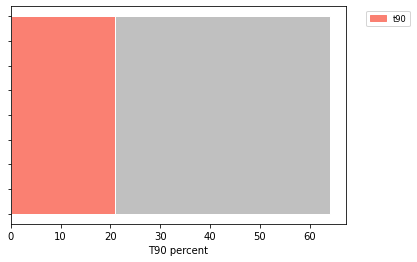

In [316]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
t90 = [100*t_90percent] 
'''NOTE'''
#here because our t90 is only 0.2%, it is hard to show
#we pretend that t90 is 20%, we time 100 in front of t90, but in real code, we shouldn't do that
#t_90per=20

not_90=100-t_90
not_90=[not_90]



y = [1]
ax.set_yticklabels(['Q1'])
plt.barh(y,t_90, color='salmon', edgecolor='white')
plt.barh(y,not_90, left=t90, color='silver', edgecolor='white')
#plt.barh(y, undecided, left=[100-i for i in undecided], color='#a3acff', edgecolor='white')

#ax.set_ylabel('')
ax.set_xlabel('T90 percent')
leg1 = mpatches.Patch(color='salmon', label='t90')
#leg2 = mpatches.Patch(color='grey', label='rest')
#leg3 = mpatches.Patch(color='#FDB200', label='Undecided')
plt.legend(handles=[leg1], ncol=2,bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

print('Your T90 happens'+' '+str(t_90)+' '+'seconds in total for the night.')
print('Your T90 percentage of the night is'+' '+str(t_90percent)+' '+'%')
plt.show() 

<ipython-input-297-bf1a86987d57>:26: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie([percent[i] / max(percent) * percent_circle], radius=radius, startangle=90,


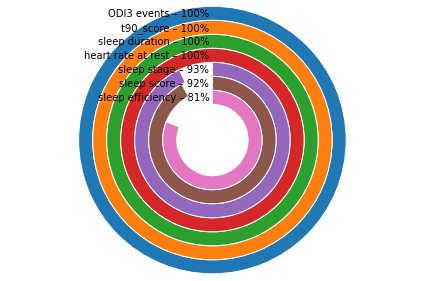

In [297]:
cathegories = ['ODI3 events','t90_score','sleep duration','heart rate at rest','sleep stage',"sleep score","sleep efficiency"]

percent = [round(ODI_score*100),round(t90_score*100),round(sleep_duration_score*100),round(heart_rate_score*100),
          round(sleep_stage_score*100),round(sleep_score*100),round(sleep_efficiency*100)]

# number of data points
n = len(percent)
# percent of circle to draw for the largest circle
percent_circle = max(percent) / 100

r = 1.5  # outer radius of the chart
r_inner = 0.4  # inner radius of the chart
# calculate width of each ring
w = (r - r_inner) / n

# create colors along a chosen colormap
#colors = [plt.cm.plasma(i / n) for i in range(n)]
colors = plt.cm.tab10.colors

# create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

for i in range(n):
    radius = r - i * w
    ax.pie([percent[i] / max(percent) * percent_circle], radius=radius, startangle=90,
           counterclock=False,
           colors=[colors[i]],
           labels=[f'{cathegories[i]} – {percent[i]}%'], labeldistance=None,
           wedgeprops={'width': w, 'edgecolor': 'white'})
    ax.text(0, radius - w / 2, f'{cathegories[i]} – {percent[i]}% ', ha='right', va='center')

# plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1.1), prop={'size': 12})
plt.tight_layout()
plt.ioff()
plt.show()

<ipython-input-174-ba45000a9bc9>:26: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie([percent[i] / max(percent) * percent_circle], radius=radius, startangle=90,


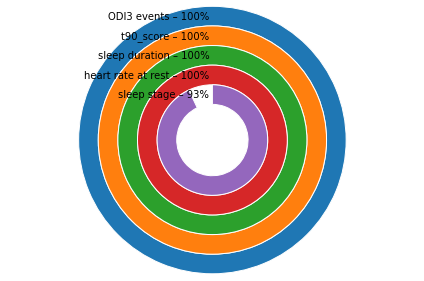

In [174]:
cathegories = ['ODI3 events','t90_score','sleep duration','heart rate at rest','sleep stage']

percent = [round(ODI_score*100),round(t90_score*100),round(sleep_duration_score*100),round(heart_rate_score*100),
          round(sleep_stage_score*100)]

# number of data points
n = len(percent)
# percent of circle to draw for the largest circle
percent_circle = max(percent) / 100

r = 1.5  # outer radius of the chart
r_inner = 0.4  # inner radius of the chart
# calculate width of each ring
w = (r - r_inner) / n

# create colors along a chosen colormap
#colors = [plt.cm.plasma(i / n) for i in range(n)]
colors = plt.cm.tab10.colors

# create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

for i in range(n):
    radius = r - i * w
    ax.pie([percent[i] / max(percent) * percent_circle], radius=radius, startangle=90,
           counterclock=False,
           colors=[colors[i]],
           labels=[f'{cathegories[i]} – {percent[i]}%'], labeldistance=None,
           wedgeprops={'width': w, 'edgecolor': 'white'})
    ax.text(0, radius - w / 2, f'{cathegories[i]} – {percent[i]}% ', ha='right', va='center')

# plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1.1), prop={'size': 12})
plt.tight_layout()
plt.ioff()
plt.show()

<ipython-input-173-827e01462d8b>:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie([percent[i] / max(percent) * percent_circle], radius=radius, startangle=90,


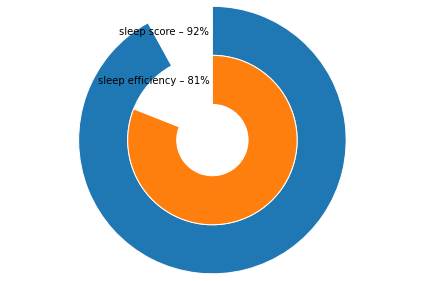

In [173]:
cathegories = ["sleep score","sleep efficiency"]

percent = [round(sleep_score*100),round(sleep_efficiency*100)]

# number of data points
n = len(percent)
# percent of circle to draw for the largest circle
percent_circle = max(percent) / 100

r = 1.5  # outer radius of the chart
r_inner = 0.4  # inner radius of the chart
# calculate width of each ring
w = (r - r_inner) / n

# create colors along a chosen colormap
#colors = [plt.cm.plasma(i / n) for i in range(n)]
colors = plt.cm.tab10.colors

# create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

for i in range(n):
    radius = r - i * w
    ax.pie([percent[i] / max(percent) * percent_circle], radius=radius, startangle=90,
           counterclock=False,
           colors=[colors[i]],
           labels=[f'{cathegories[i]} – {percent[i]}%'], labeldistance=None,
           wedgeprops={'width': w, 'edgecolor': 'white'})
    ax.text(0, radius - w / 2, f'{cathegories[i]} – {percent[i]}% ', ha='right', va='center')

# plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1.1), prop={'size': 12})
plt.tight_layout()
plt.ioff()
plt.show()

# HRV calculation

In this section, we are going to try to calculate HRV by giving RMSSD and SDNN
the current given data is by second but for the purpose of coding, we assume it is given by ms abd heart rate times 10 as an arbitrary ECG data. 
Because the data is extremely random and it DOES NOT REPRESENT ECG in anyway. IT MAKES SENSE THAT THE FOLLOWING RESULT DO NOT MAKE SNESE YET.
Once we have the ECG/EKG data, we will try again and we can test if this algorithm works or not. 


In [320]:
df1.head()

oxy_level  pulse_sec  stage_min  stage_sec   baseline
0      97.93         68        0.0        0.0  97.930000
1      98.07         68        0.0        0.0  98.000000
2      98.23         68        0.0        0.0  98.076667
3      98.39         68        0.0        0.0  98.155000
4      98.60         68        0.0        0.0  98.244000

In [321]:
heartrate=df1['pulse_sec']
df2 = pd.DataFrame(heartrate)
df2['heartrate']=heartrate*6

In [322]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for ECG sensor
settings = {}
settings['fs'] = 500

In [323]:
df2.head()

pulse_sec  heartrate
0         68        408
1         68        408
2         68        408
3         68        408
4         68        408

In [324]:
heartrate.mean()

60.013952344134395

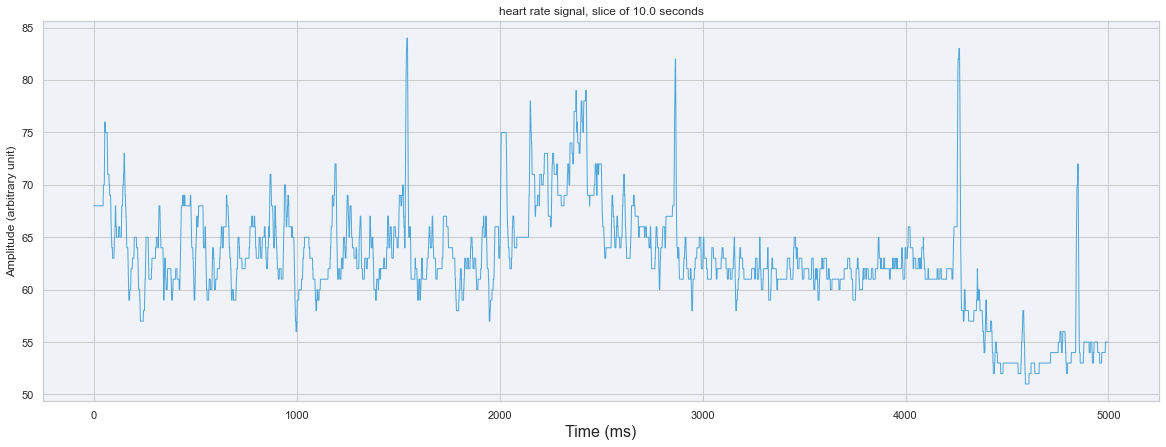

In [325]:
plt.figure(figsize=(20, 7))

plt.ioff()
start = 0
stop = 5000
duration = (stop-start) / settings['fs']
plt.title("heart rate signal, slice of %.1f seconds" % duration)
plt.plot(df2[start:stop].index, df2[start:stop].pulse_sec, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

<IPython.core.display.Javascript object>


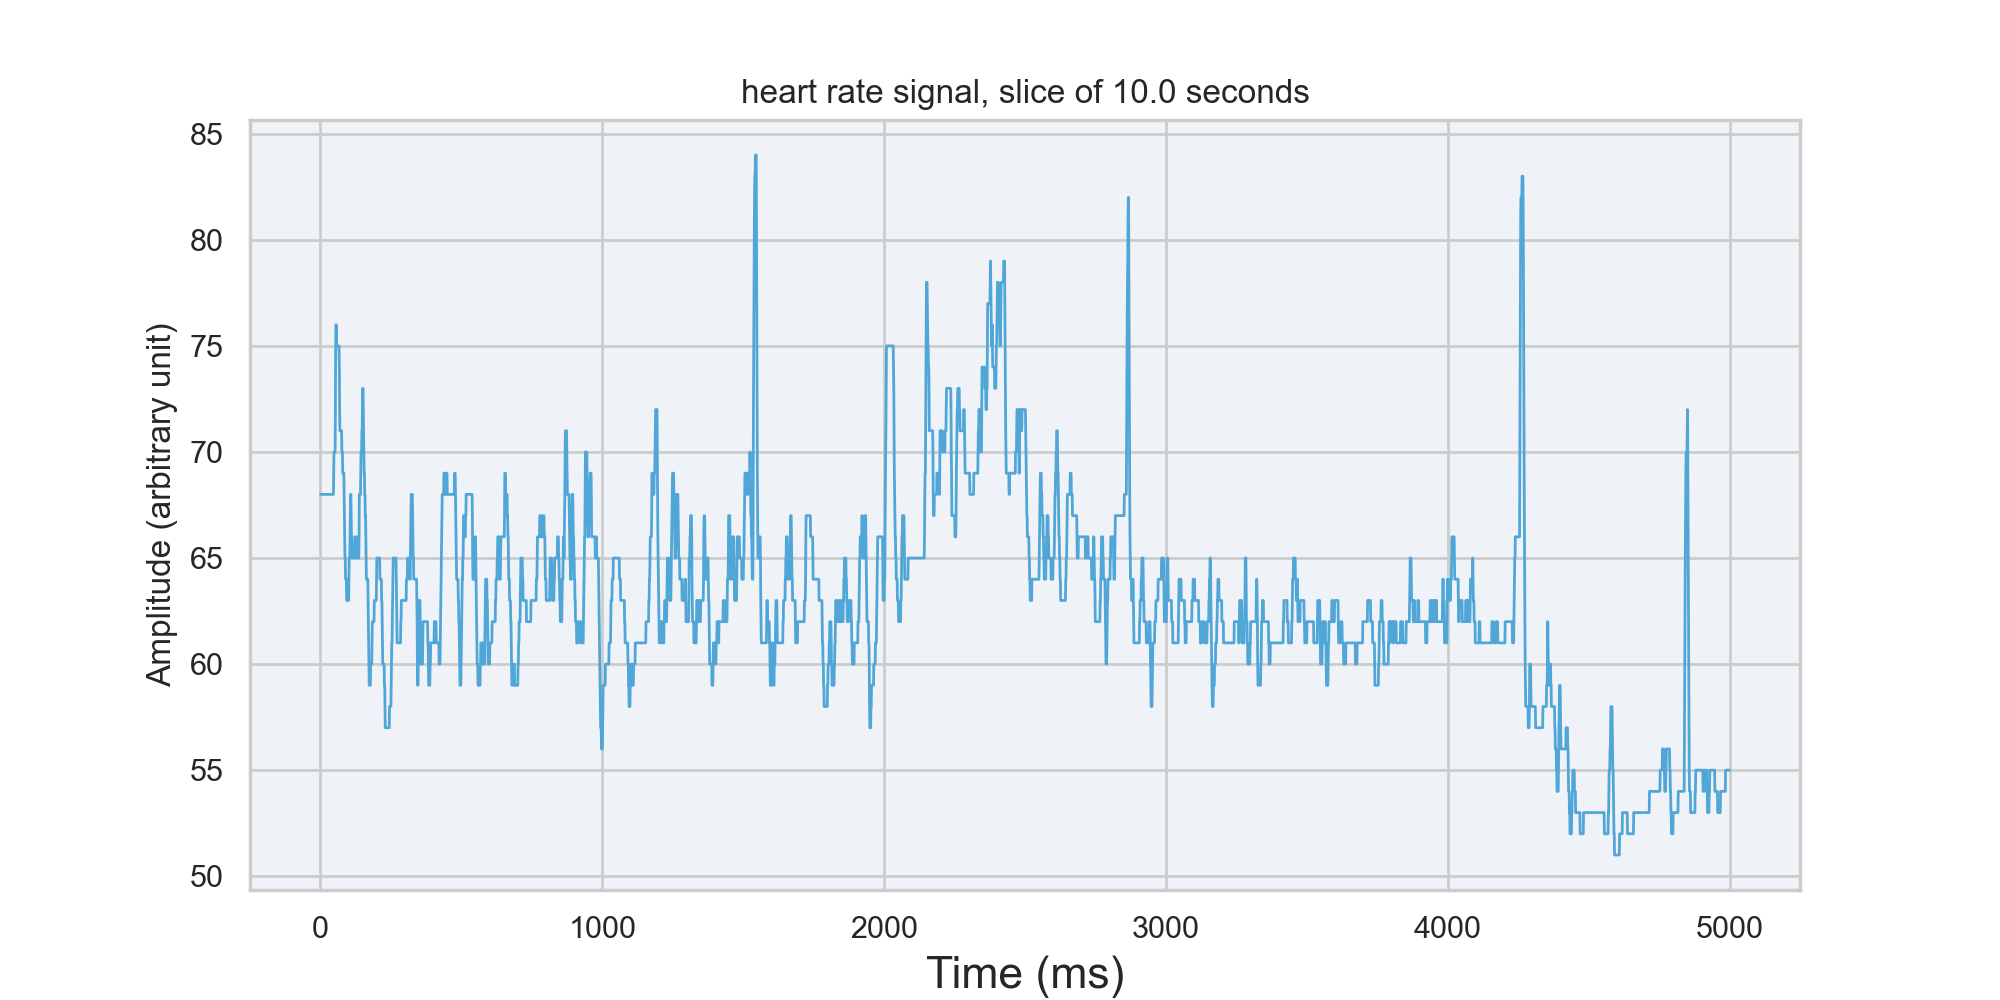

In [326]:
#interavtive graph: pulse 
#%matplotlib notebook  uncomment this to make it interactive
plt.figure(figsize=(10, 5))

plt.ioff()
start = 0
stop = 5000
duration = (stop-start) / settings['fs']
plt.title("heart rate signal, slice of %.1f seconds" % duration)
plt.plot(df2[start:stop].index, df2[start:stop].pulse_sec, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

In [327]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity


In [328]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [329]:
df2.index

RangeIndex(start=0, stop=28454, step=1)

In [330]:
sampfrom = 10000
sampto = 20000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df2.index >= start) & (df2.index < stop) 
    ecg_slice = df2.heartrate[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(450, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")
    

In [331]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

<IPython.core.display.Javascript object>


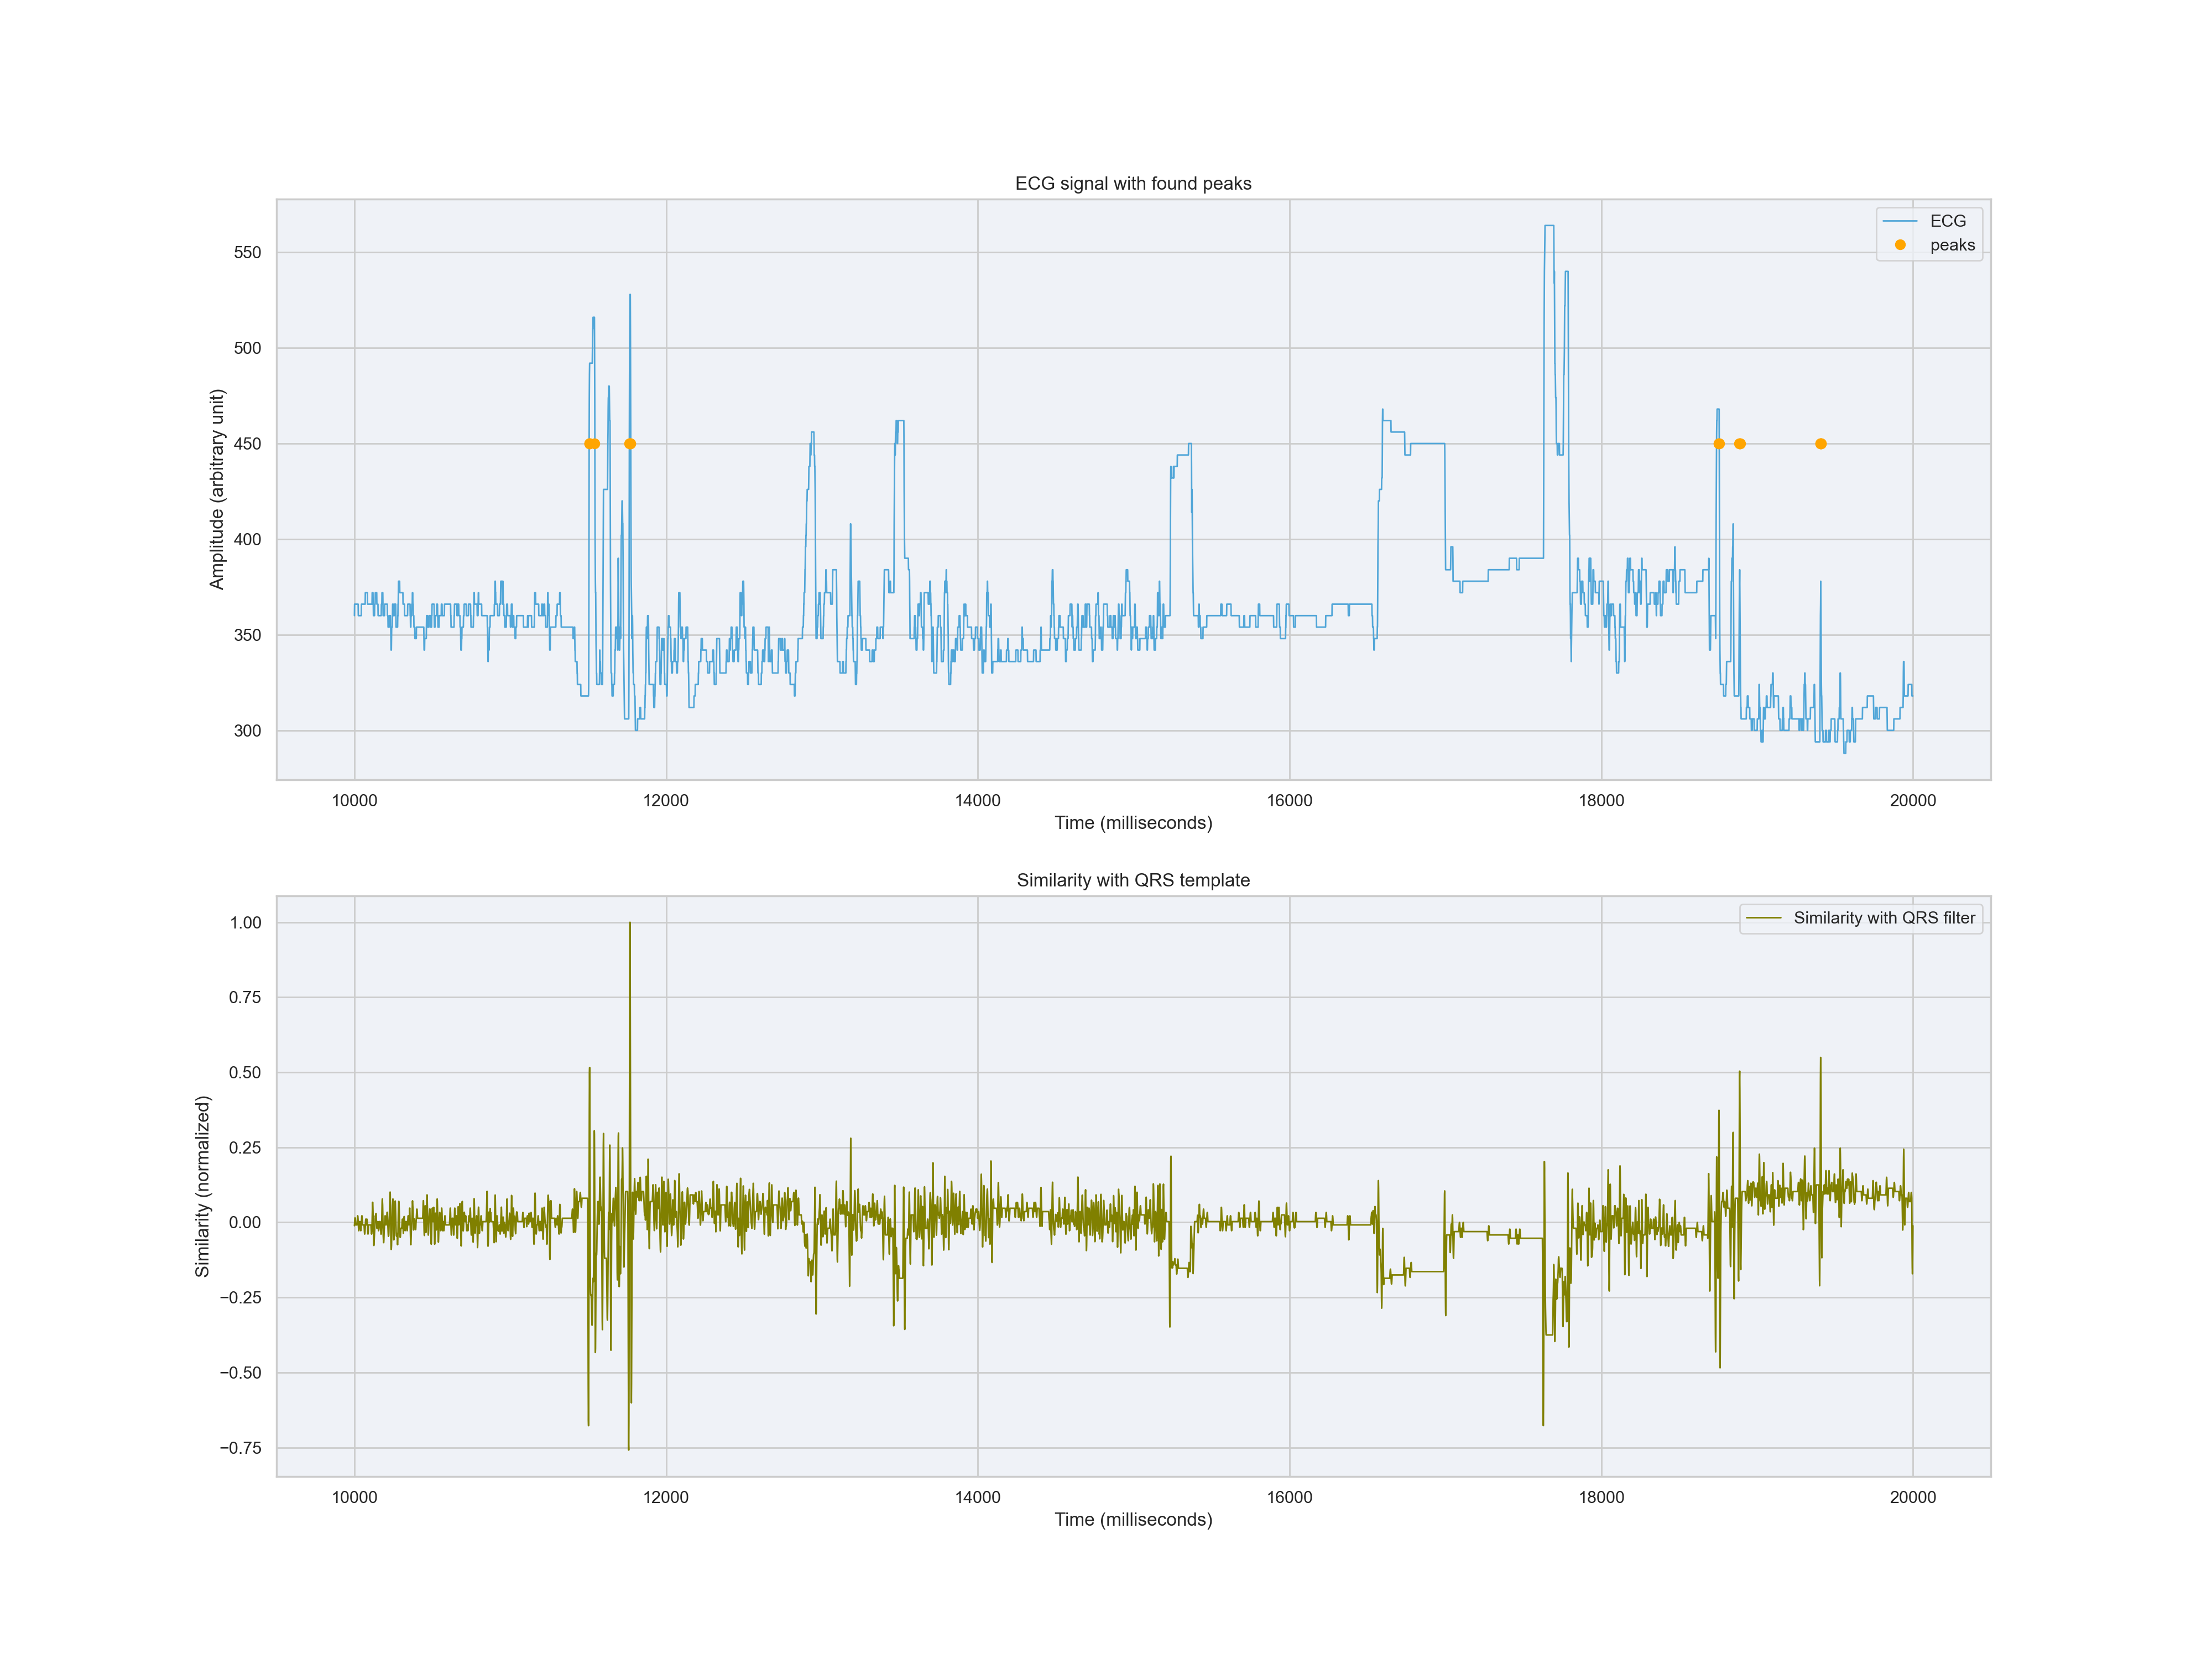

<IPython.core.display.Javascript object>


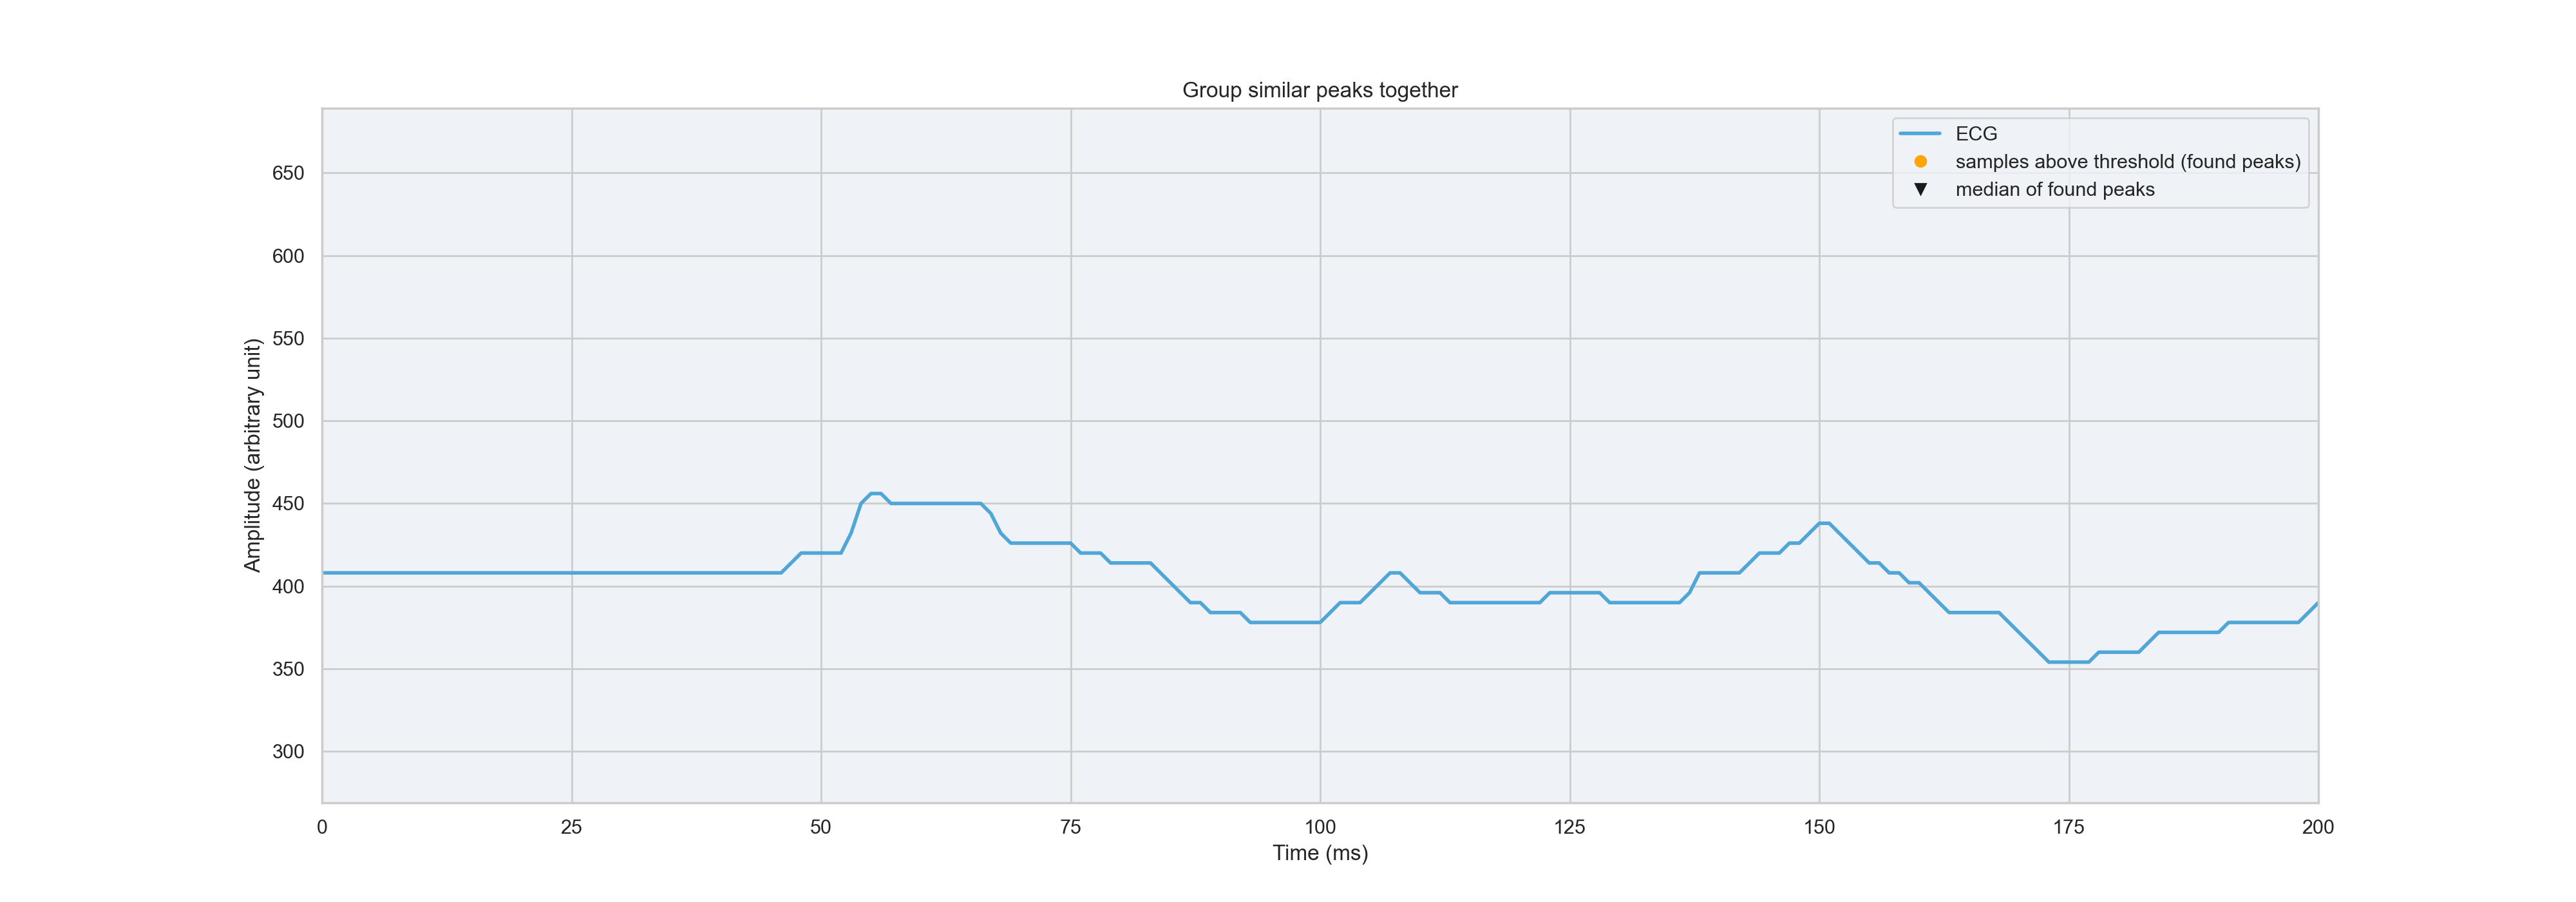

In [332]:
# detect peaks
peaks, similarity = detect_peaks(df2.heartrate, threshold=0.3)

# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(df2.index, df2.heartrate, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(450, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(670, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()

<IPython.core.display.Javascript object>


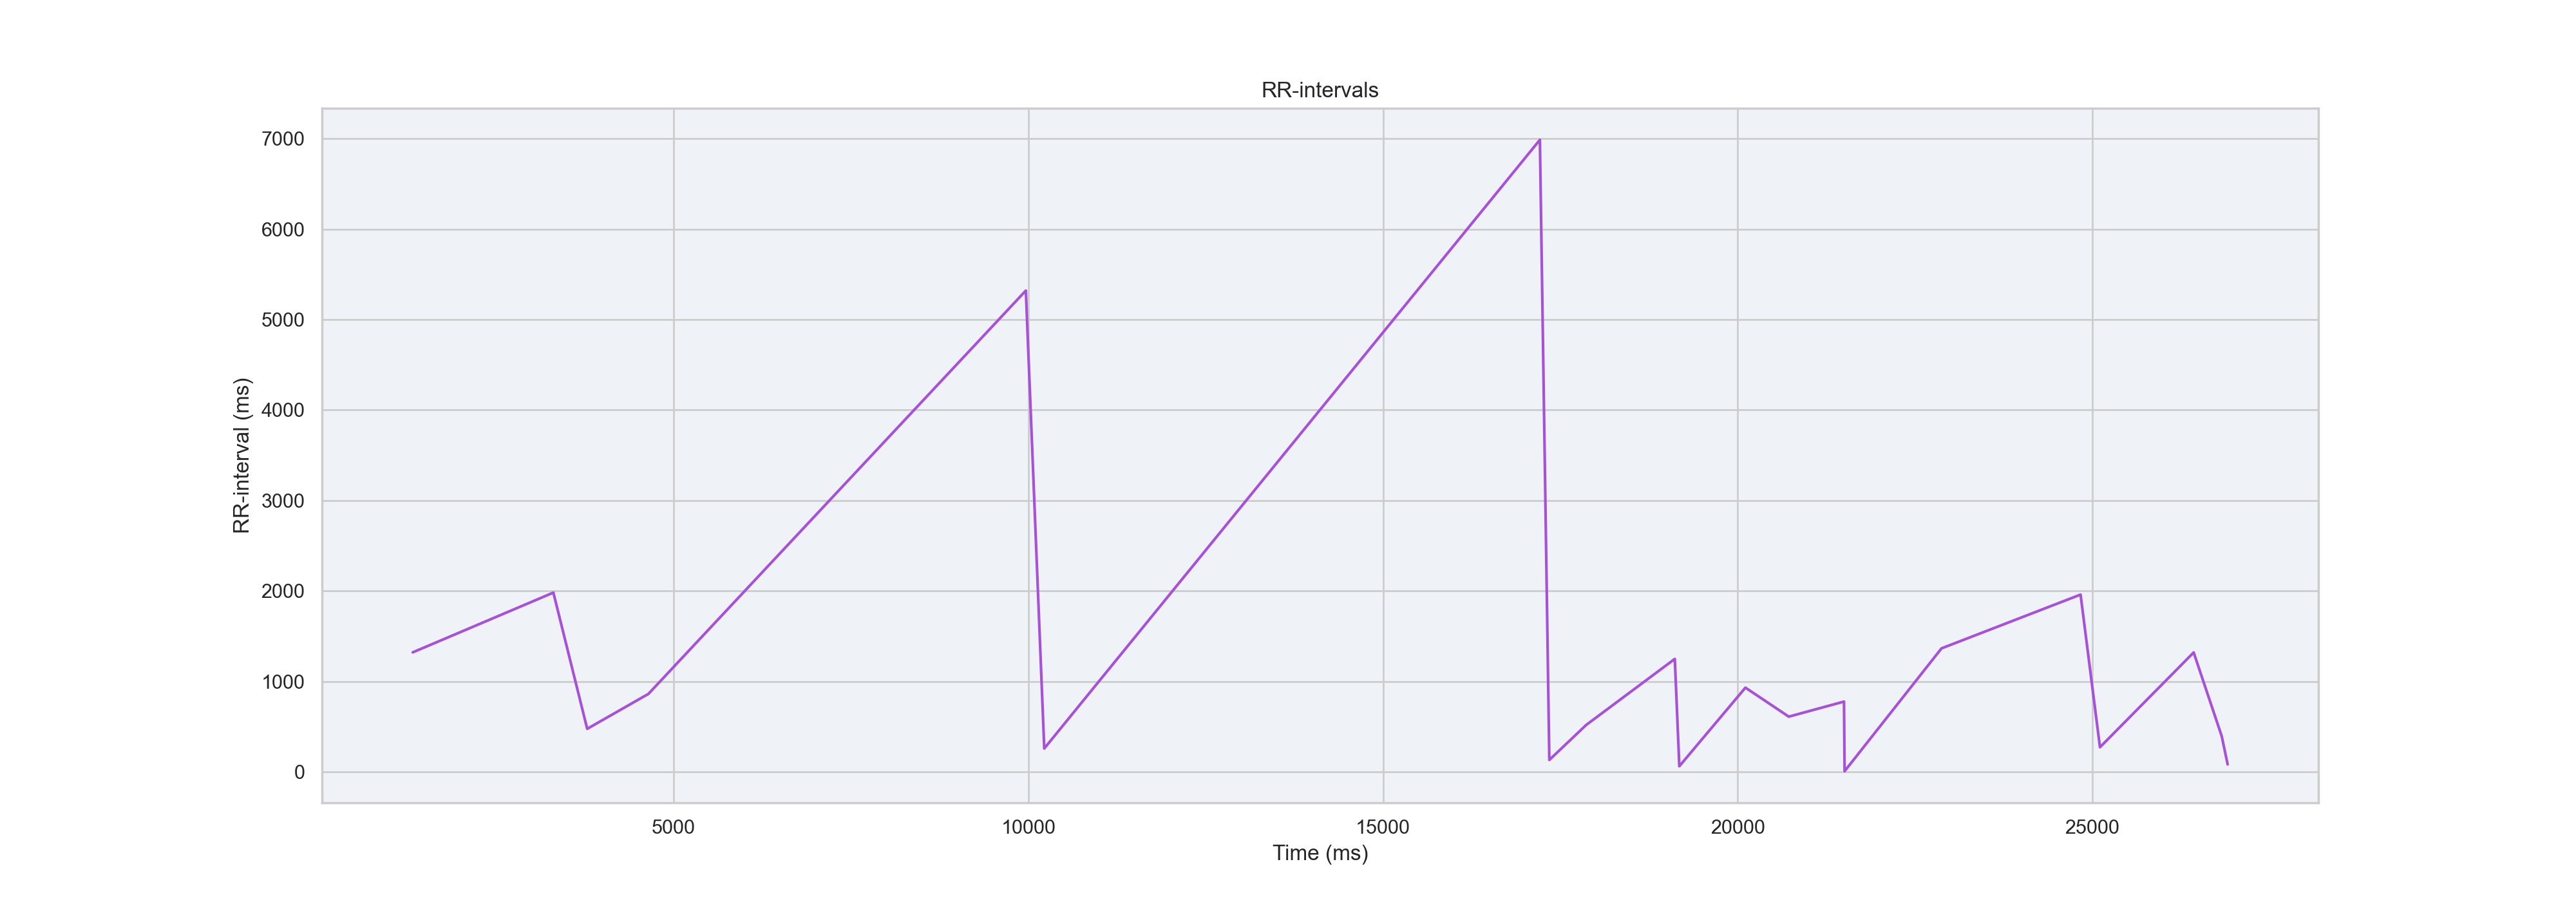

In [333]:
# detect peaks
peaks, similarity = detect_peaks(df2.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

# plot RR-intervals
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8")
plt.show()

<IPython.core.display.Javascript object>


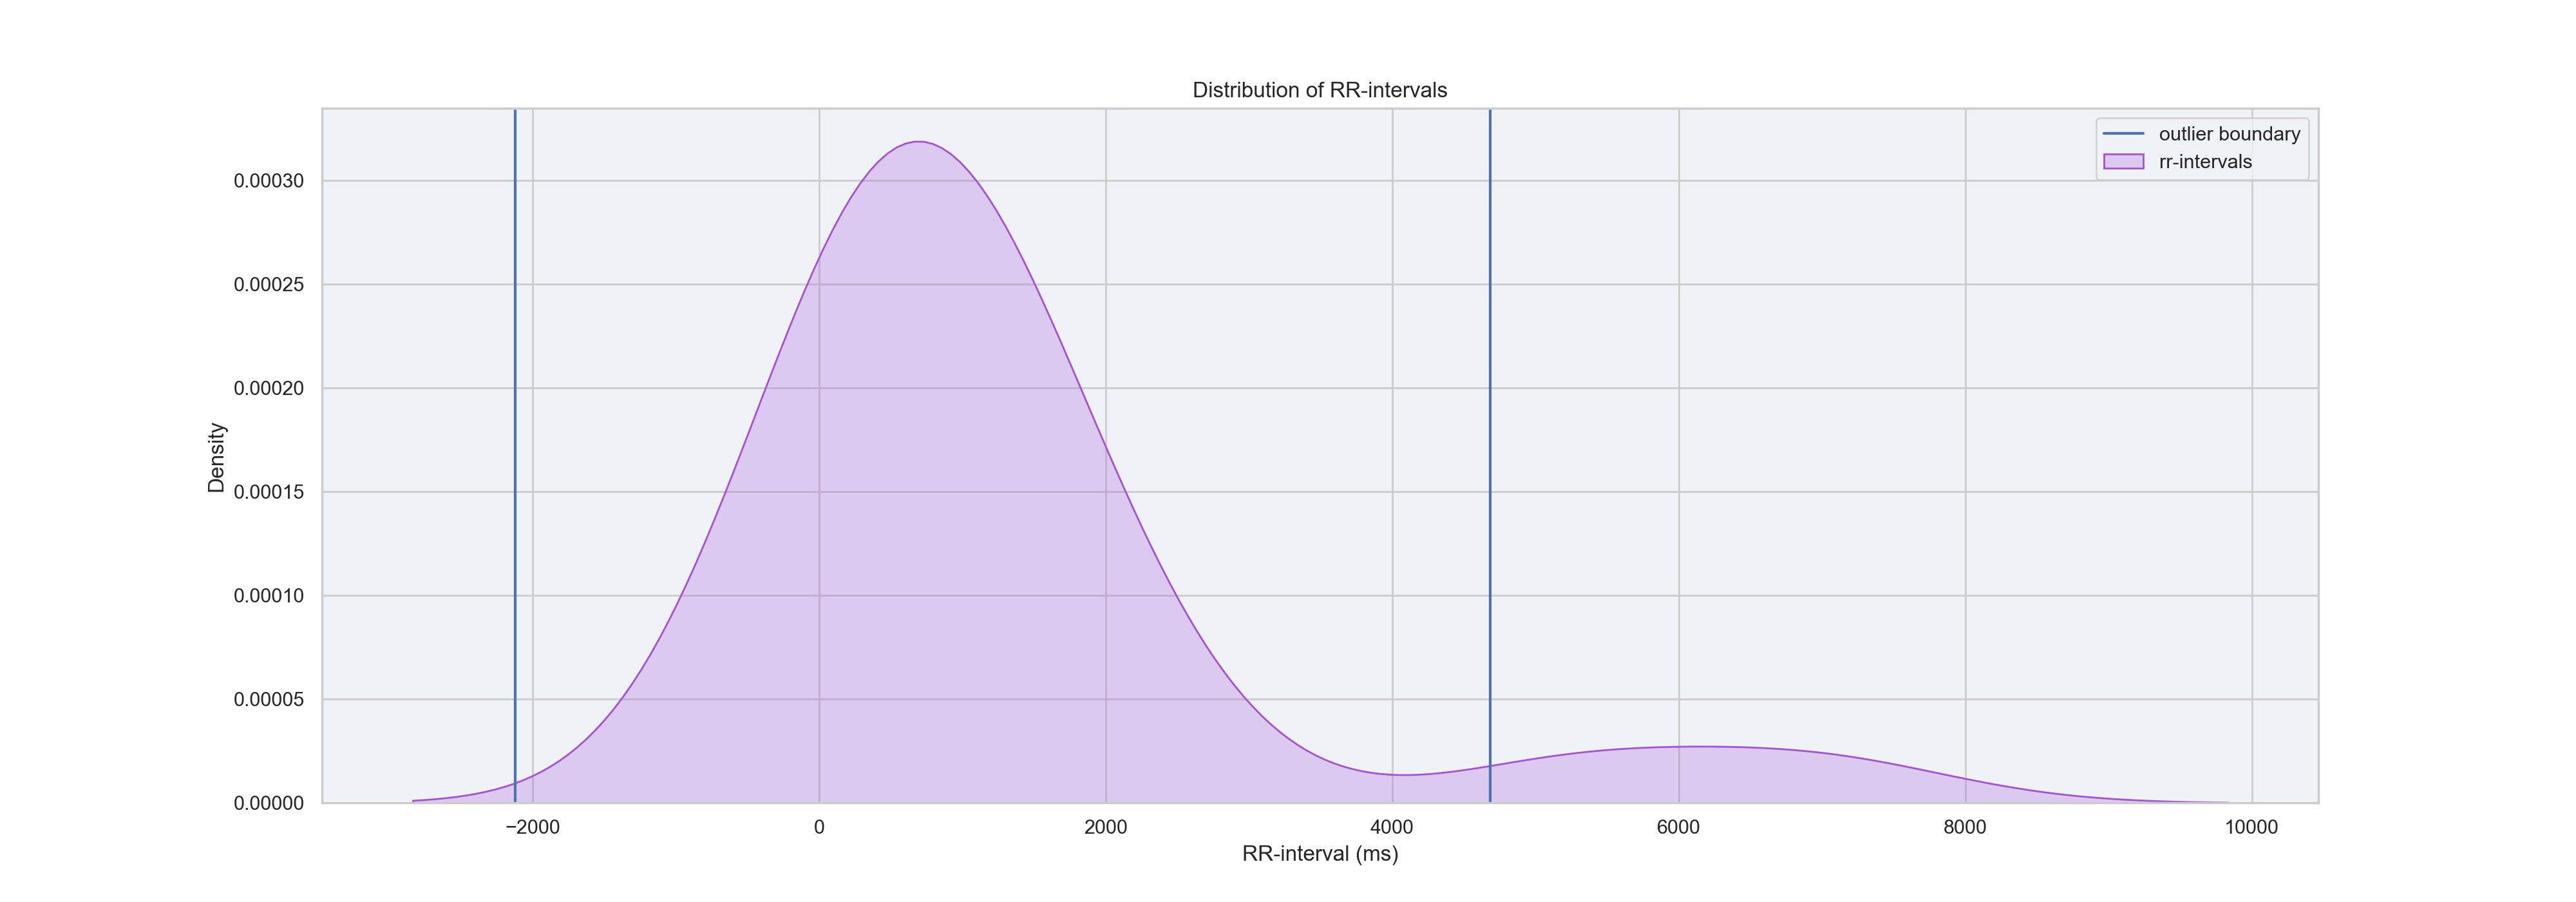

In [334]:
#Erroe detection
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr) - 2 * np.std(rr)
outlier_high = np.mean(rr) + 2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


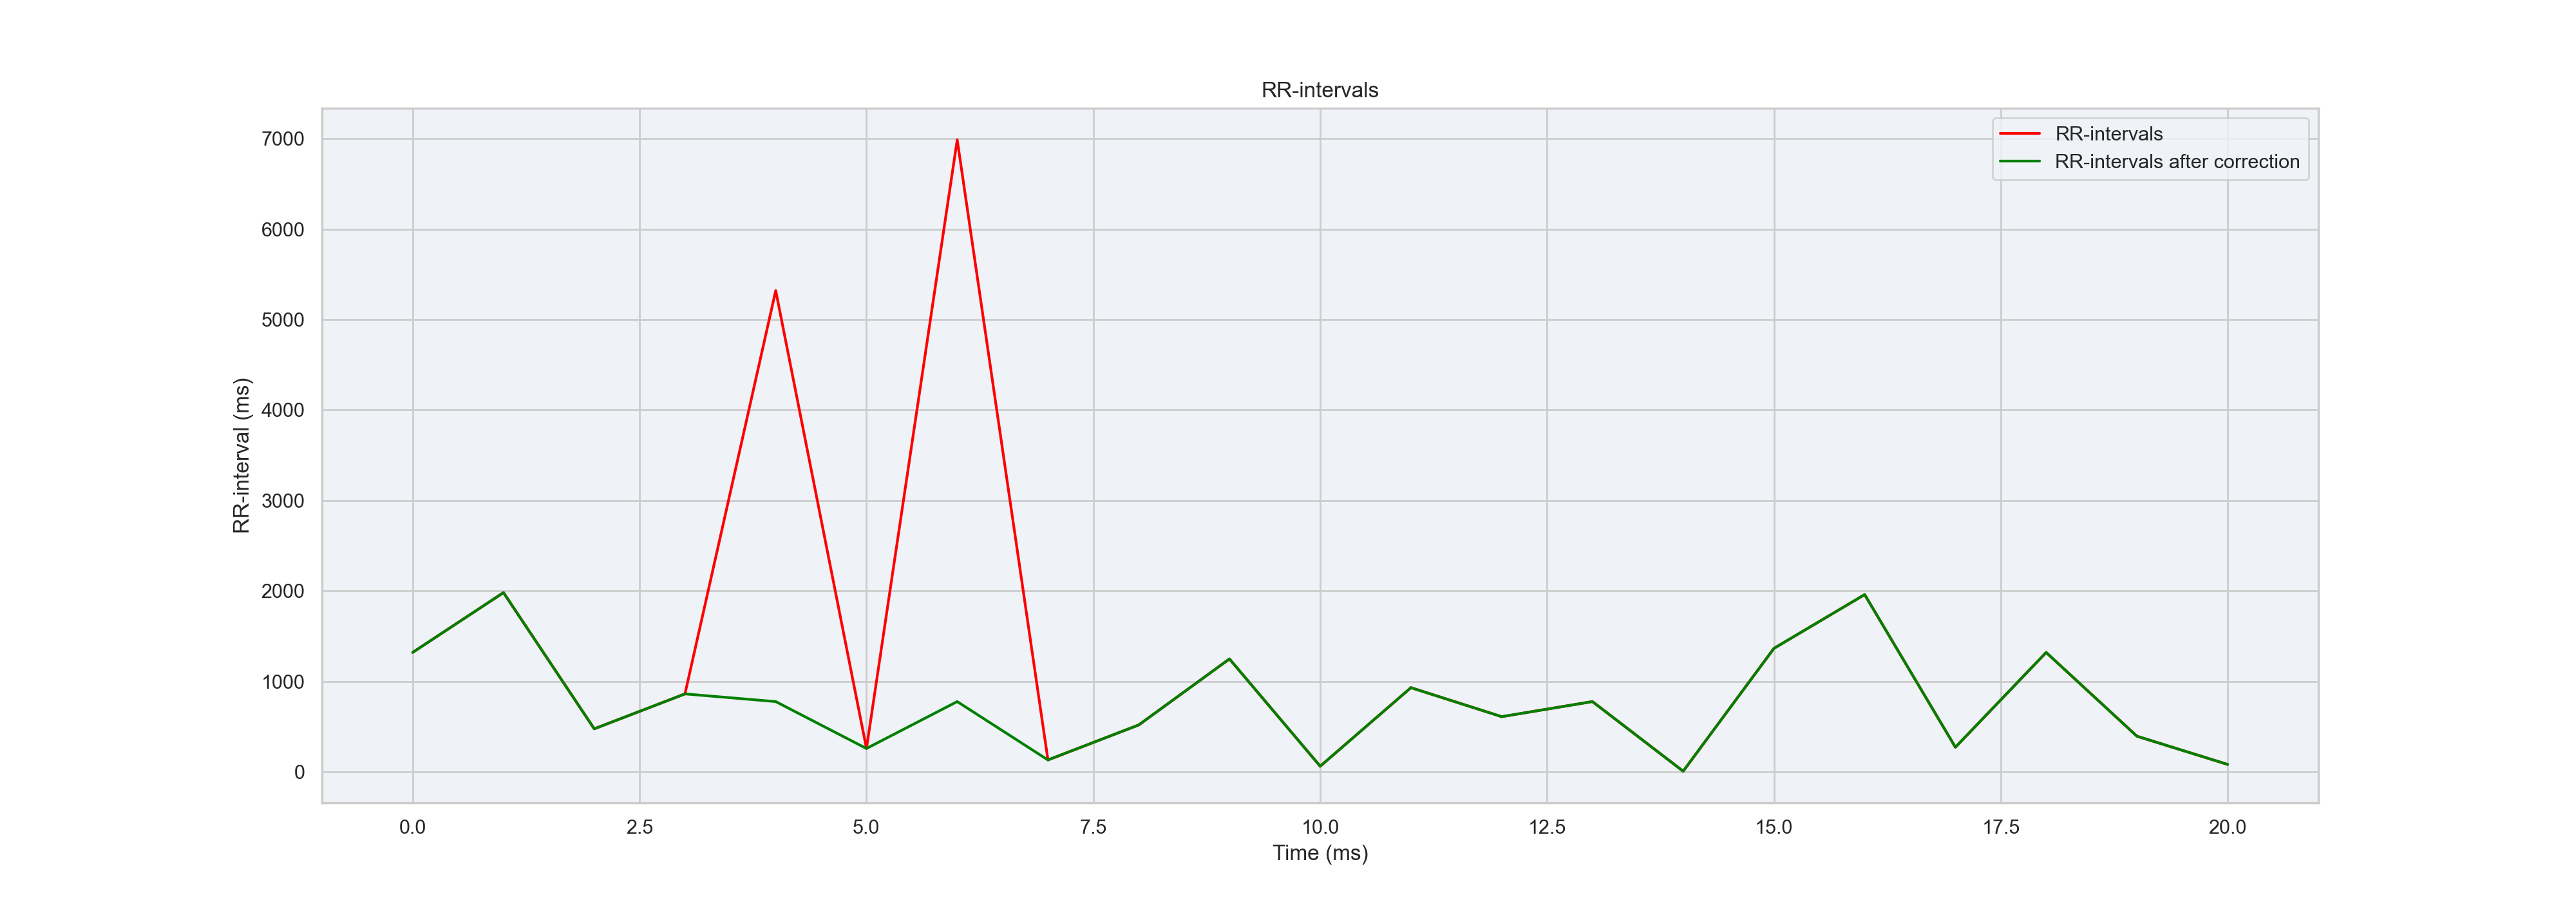

In [335]:
plt.figure(figsize=(20, 7))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()


In [336]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [337]:
sampfrom = 10000
sampto = 25000
nr_plots = 1

# detect peaks
peaks, similarity = detect_peaks(df2.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # plot similarity
    plt.figure(figsize=(20, 10))

    plt.title("ECG signal & RR-intervals")
    plt.plot(df2.index, df2.heartrate, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(grouped_peaks, np.repeat(600, grouped_peaks.shape[0]), markersize=10, label="Found peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper left")
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    plt.gca().set_ylim(0, 1000)
    
    ax2 = plt.gca().twinx()
    ax2.plot(np.cumsum(rr_corrected)+peaks[0], rr_corrected, label="Corrected RR-intervals", fillstyle="none", color="#A651D8", markeredgewidth=1, marker="o", markersize=12)
    ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="k", linewidth=2, marker=".", markersize=8)
    
    ax2.set_xlim(start, stop)
    ax2.set_ylim(-2000, 2000)
    ax2.legend(loc="upper right")
    plt.xlabel("Time (ms)")
    plt.ylabel("RR-interval (ms)")

In [338]:
print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(rr).items():
    print("- %s: %.2f" % (k, v))

print()
print("Time domain metrics - manually corrected RR-intervals:")
for k, v in timedomain(rr_corrected).items():
    print("- %s: %.2f" % (k, v))

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 1281.29
- STD RR/SDNN (ms): 1701.00
- Mean HR (Kubios' style) (beats/min): 46.83
- Mean HR (beats/min): 504.27
- STD HR (beats/min): 1484.66
- Min HR (beats/min): 8.59
- Max HR (beats/min): 7058.82
- RMSSD (ms): 2749.82
- NNxx: 20.00
- pNNxx (%): 95.24

Time domain metrics - manually corrected RR-intervals:
- Mean RR (ms): 769.31
- STD RR/SDNN (ms): 572.93
- Mean HR (Kubios' style) (beats/min): 77.99
- Mean HR (beats/min): 510.67
- STD HR (beats/min): 1482.66
- Min HR (beats/min): 30.26
- Max HR (beats/min): 7058.82
- RMSSD (ms): 850.64
- NNxx: 20.00
- pNNxx (%): 95.24


Now we try to separate the data and calcualte by every 1 mins
Hypothetical, our current data is recorded by every 3000 ms so we need 20 data points for 1 min.

In [51]:
df2

pulse_sec  heartrate
0             68        408
1             68        408
2             68        408
3             68        408
4             68        408
...          ...        ...
28449         89        534
28450         89        534
28451         89        534
28452         89        534
28453         90        540

[28454 rows x 2 columns]

In [52]:
max(df2['pulse_sec'])

94

In [53]:
rr_corrected

array([1322. , 1982.5,  477. ,  863. ,  778. ,  259.5,  778. ,  133. ,
        519.5, 1249.5,   63.5,  932. ,  611.5,  778. ,    8.5, 1366. ,
       1960.5,  273.5, 1321. ,  395.5,   83.5])

In [54]:
diff_rr=[j-i for i, j in zip(rr_corrected[:-1], rr_corrected[1:])]
#print(diff_rr)
RMSSD_ind=np.abs(diff_rr)
len(RMSSD_ind)
#np.sqrt(np.mean(np.square(np.diff(diff_rr))))

20

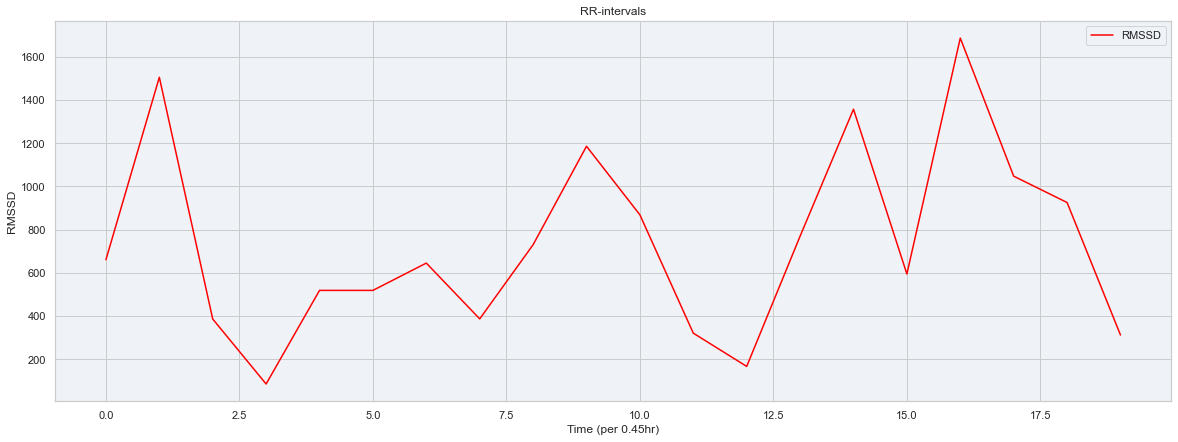

In [55]:
plt.figure(figsize=(20, 7))



plt.title("RR-intervals")
plt.xlabel("Time (per 0.45hr)")
plt.ylabel("RMSSD")

plt.plot(RMSSD_ind, color="red", label="RMSSD")
#plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

In [56]:
#lst_number=RMSSD_ind/60 # this later on can be changed to how many mins in total/5mins=how many list
rmssd_lst=np.array_split(RMSSD_ind, 8)

#lst=np.sqrt(np.mean(np.square(np.diff(rmssd_lst[1]))))
#lst

rmssd_lst

[array([ 660.5, 1505.5,  386. ]),
 array([ 85. , 518.5, 518.5]),
 array([645. , 386.5, 730. ]),
 array([1186. ,  868.5,  320.5]),
 array([166.5, 769.5]),
 array([1357.5,  594.5]),
 array([1687. , 1047.5]),
 array([925.5, 312. ])]

In [57]:
final_lst=[]
for i in rmssd_lst:
    final_lst.append(np.sqrt(np.mean(np.square(np.diff(i)))))
print(final_lst)
    
len(final_lst)

[991.7926320557135, 306.5307896443683, 303.9856082119678, 447.8338140426647, 603.0, 763.0, 639.5, 613.5]


8

<IPython.core.display.Javascript object>


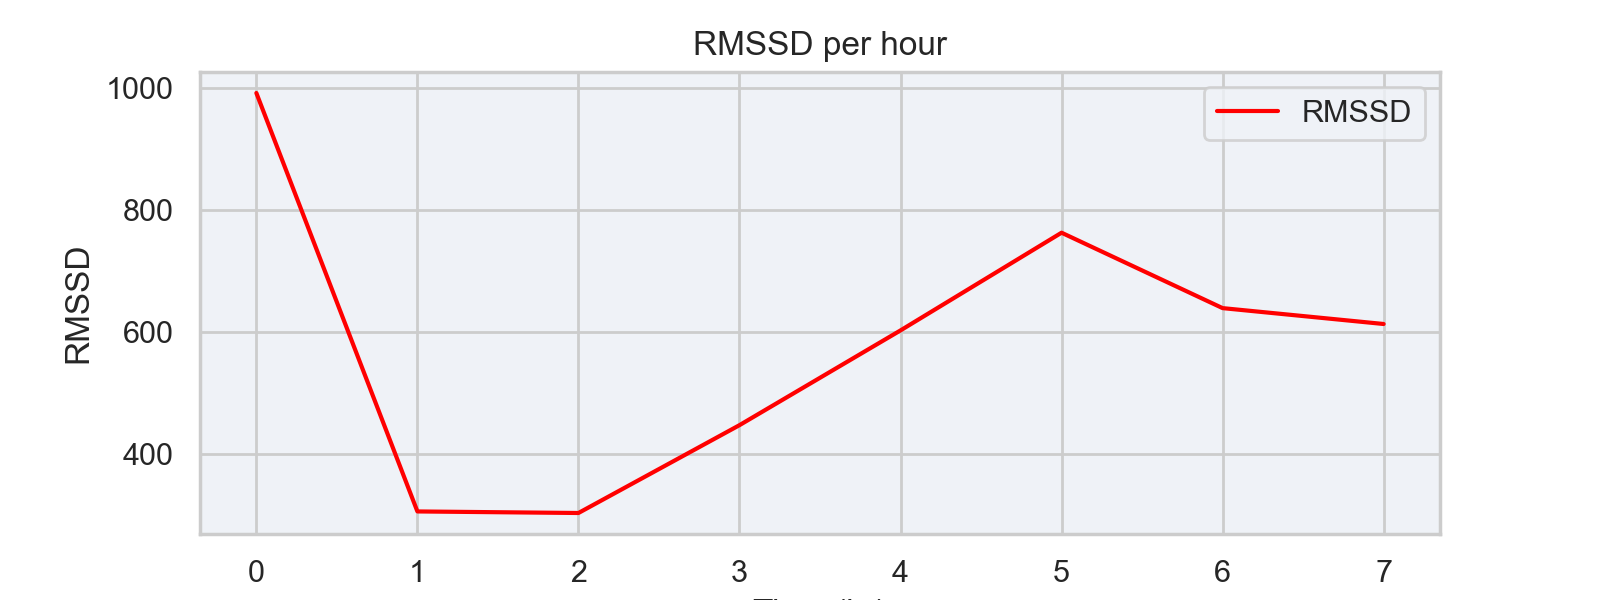

In [58]:
#%matplotlib notebook uncomment it to make it interactive
plt.figure(figsize=(8, 3))

plt.title("RMSSD per hour")
plt.xlabel("Time (hr)")
plt.ylabel("RMSSD")




plt.plot(final_lst, color="red", label="RMSSD")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


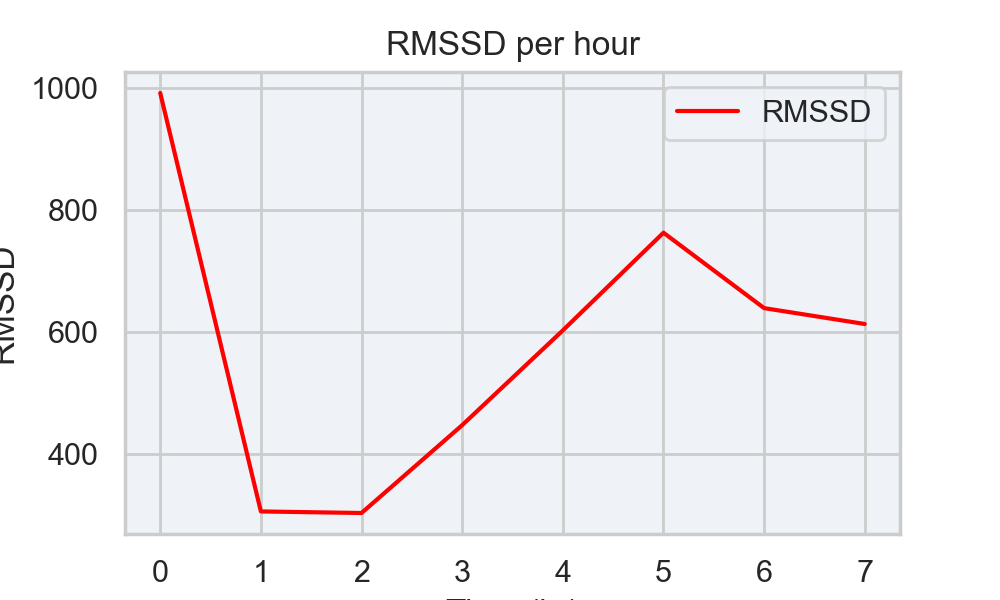

In [59]:
import mpld3
mpld3.enable_notebook()
plt.figure(figsize=(5, 3))

plt.title("RMSSD per hour")
plt.xlabel("Time (hr)")
plt.ylabel("RMSSD")




plt.plot(final_lst, color="red", label="RMSSD")

plt.legend()
plt.show()